<h1>TracksMining </h1>

<i>Quentin WATTHEZ <br>
    Département de l'Etude du Milieu Naturel et Agricole<br>
    quentin.watthez@spw.wallonie.be
</i>

<p> 
Ce document contient le code source nécessaire à l'application TracksMining.
L'application peut s'exécuter via Jupyter Notebook, à condition de:<br>
    - Créer un répertoire sur son disque local, avec la structure définie dans le rapport de TFE.<br>
    - Installer les dépendances nécessaires<br>
<p>

<div class="alert alert-block alert-success"> 
<h1> Partie 1 :Modèle </h1>
    <p> Le modèle contient l'ensemble des classes qui définissent les calculs</p>
</div>

<h1> A. Classes Utilitaires </h1>

<h2> Classe Logger </h2>
<p> La classe Logger sert à définir un objet qui permet de répertorier l'ensemble des variables calculées par le programme, sous forme d'une classification arborescente. </p>

In [1]:
class Logger():
    
    def __init__(self):
        print("Setting up Logger ")
        self.records = {}
    
    def update_metrics(self, target_class):
        """Update records with metrics from the target class"""
        slot = target_class.metrics_foldername
        
        if slot in self.records:
            self.records[slot] = {**self.records[slot],
                                  **target_class.metrics}
        else:
            self.records[slot] = target_class.metrics
    
    def hide_slots(self, display_log):
        """Mask some results if too heavy for console display"""
        display_log['geocomputer']['coordinates']['UTM'] = "Not displayed"
        display_log['geocomputer']['coordinates']['WGS84'] = "Not displayed"
        display_log['geocomputer']['locations_geojson']= "Not displayed"
        display_log['geocomputer']['trajectories_geojson']= "Not displayed"
        if 'interactioncomputer' in display_log.keys():
            display_log['interactioncomputer']['interaction_geojson']= "Not displayed"
            display_log['interactioncomputer']['interaction_dataframe']= "Not displayed"
        if 'gridcellcomputer' in display_log.keys():
            display_log['gridcellcomputer']['gridcell_geojson']= "Not displayed"
            display_log['gridcellcomputer']['gridcell_dataframe']= "Not displayed"

    def display(self):
        """Provide a nice structured display in the console"""
        import pprint
        
        display_log = self.records
        self.hide_slots(display_log)
        
        print("##### LOGGER #####")
        pprint.pprint(display_log)
        

<h2> Classe Data </h2>
<p> La classe Data sert à stocker les bases de données. </p>

In [2]:
class Data():
    
    def __init__(self):
        print("Setting up Data ")
    
    def read_locations(self, file):
        path_to_file = f"../data/positions/{file}" 
        self.locs = pd.read_csv(path_to_file, sep=None, engine='python', usecols=['LAT','LON','TIME','DOP'])

    def get_nlocs(self):
        return len(self.locs)
    
    def display_locations(self):
        """Provide a nice structured display in the console"""
        print("##### DATA #####")
        print(self.locs)
    
    def display_locations_columns(self):
        """Print a list of columns in the dataframe"""
        print(self.locs.columns.values)
    
    def create_trajectories_dataframe(self):
        self.trajectories = pd.DataFrame()


<h2> Classe Settings </h2>
<p> La classe Settings sert à instancier les paramètres à partir du fichier Excel et à les formatter. </p>

In [3]:
class Settings(): 
    
    def __init__(self):
        print("Setting up settings")
        self.path = "../settings/settings.xls"
    
    def read(self):
        """Read the settings"""
        self.values = pd.read_excel(self.path, usecols=['PARAMETER','VALUE'])
    
    def delete_empty_fields(self):
        """Remove empty fields from the settings dict"""
        self.values = self.values[self.values['PARAMETER']==self.values['PARAMETER']]
        self.values.reset_index(inplace=True, drop=True)

    def set_NAN_values_to_false(self):
        """Replace all NAN values with False"""
        self.values.fillna('False', inplace=True)

    def convert_boolean_values(self):
        """Replace 'True' and 'False' with boolean equivalent"""
        self.values['VALUE'] = self.values['VALUE'].replace('True', True)
        self.values['VALUE'] = self.values['VALUE'].replace('False', False)

    def convert_to_dict(self):
        """Creation of a settings dictionnary object"""
        self.dict = {}
        for line in self.values.itertuples(index=True):
            parameter = line.PARAMETER
            value = line.VALUE
            self.dict[parameter]=value

    def convert_float_values(self):
        """Make sure adequate values are converted to float"""
        self.dict['west_limit']=float(self.dict['west_limit'])
        self.dict['east_limit']=float(self.dict['east_limit'])
        self.dict['north_limit']=float(self.dict['north_limit'])
        self.dict['south_limit']=float(self.dict['south_limit'])
        self.dict['min_dop']=float(self.dict['min_dop'])
    
    def display(self):
        """Provide a nice structured display in the console"""
        import pprint
        print("##### SETTINGS #####")
        pprint.pprint(self.dict)


<h2> Fonction chrono </h2>
<p> La fonction chrono est un décorateur qui permet de calculer le temps d'exécution des fonctions du programme </p>

In [69]:
def chrono(function):
    """A decorator function to compute time processing of a function"""
    def inner(*args, **kwargs):
        start = time.time()
        result = function(*args, **kwargs)
        stop = time.time()
        print(f"""{function.__name__}: {round((stop - start),6)} s""")
        return result
    return inner

<h2> Classe Converter </h2>
<p> La classe Converter prend en charge les opérations de conversion entre systèmes de référence de coordonnées </p>

In [67]:
class Converter():
    """A class to perform easy geographical conversions"""
    
    @ log_decorator(chrono_dico)
    def __init__(self):
        print("Setting up Converter ")
        self.WGS84 = 'EPSG:4326'
        self.create_metrics()
    
    def create_metrics(self):
        """Create the class-related metrics folder"""
        self.metrics = {}
        self.metrics_foldername = "converter"
    
    def find_best_UTM_CRS(self, df):
        """Find the most appropriate UTM zone"""
        from pyproj import CRS
        from pyproj.aoi import AreaOfInterest
        from pyproj.database import query_utm_crs_info
        
        area_of_interest = AreaOfInterest(west_lon_degree=min(df['LON']),
                                              south_lat_degree=min(df['LAT']),
                                              east_lon_degree=max(df['LON']),
                                              north_lat_degree=max(df['LAT']),
                                              )
        
        utm_crs_list = query_utm_crs_info(datum_name="WGS 84",
                                          area_of_interest=area_of_interest)
        
        utm_crs = CRS.from_epsg(utm_crs_list[0].code)
        utm_crs = utm_crs.to_authority()
        self.UTM = f"{utm_crs[0]}:{utm_crs[1]}"
        self.metrics['UTM_CRS'] = self.UTM
        self.metrics['WGS84'] = 'EPSG:4326'
        # Once recorded in logger, conversion to pyproj
        self.UTM = CRS(self.UTM)
        self.WGS84 = CRS('EPSG:4326')
    
    def define_projections(self):
        """Create the projection objects to be called later by convert function"""
        from pyproj import Transformer
        self.projections = {'to_WGS84': Transformer.from_crs(self.UTM,self.WGS84,always_xy=True).transform,
                            'to_WGS84_reverse' : Transformer.from_crs(self.UTM,self.WGS84,always_xy=False).transform,
                            'to_UTM' : Transformer.from_crs(self.WGS84,self.UTM,always_xy=False).transform,
                            'to_UTM_reverse' : Transformer.from_crs(self.WGS84,self.UTM,always_xy=True).transform
                           }
        
    def convert(self, shape, how):
        """Convert object from CRS to another"""
        from shapely.ops import transform
        projection = self.projections.get(how)
        converted_shape = transform(projection, shape)
        return converted_shape

<h1> B. Classes de traitement </h1>

<h2>classe DataScanner</h2>
<p>La classe DataScanner comprend les méthodes qui permettent de récolter des informations basiques sur le fichier, et vérifier qu'il soit conforme au format attendu pour la suite du traitement.<p>

In [6]:
class DataScanner():
    """A class to scan a dataframe"""
    
    def __init__(self):
        print("Data Scanning")
        self.create_metrics()
    
    def create_metrics(self):
        """Create the class-related metrics folder"""
        self.metrics = {}
        self.metrics_foldername = "datachecker"
    
    def get_current_timestamp(self):
        """Get a timestamp of the time of process"""
        from datetime import datetime
        self.metrics['application_timestamp'] = datetime.now().strftime("%d/%m/%y %H:%M:%S")

    def check_minimal_columns(self, df):
        """Check if essential columns are in the dataframe"""
        print('Vérification des colonnes minimales')
        columns_list=['TIME','LON','LAT','DOP'] 
        for i in columns_list:
            assert i in df.columns.values, f"colonne {i} manquante"
            
    def get_size(self, df):
        """Count lines in the dataframe(header excluded)"""
        print('Comptage du nombre de lignes')
        self.metrics['n_locations'] = len(df)
        assert len(df) >=3, "Pas assez de données dans le jeu de données"
        assert len(df) <100000, "Trop de données dans le jeu de données.  Veuillez scinder les données."

    def parse_time(self, df):
        """Conversion of the TIME column from String to Date"""
        print('Conversion de la date')
        
        mapping=['%d/%m/%y %H:%M:%S',
                 '%d-%m-%y %H:%M:%S',
                 '%Y-%m-%d %H:%M:%S', 
                 '%d/%m/%y %H:%M:%S %Z', 
                 '%d/%m/%Y %H:%M:%S %Z', 
                 '%d/%m/%y %H:%M',
                 '%d-%m-%y %H:%M',
                 '%d/%m/%Y %H:%M:%S',
                 '%d/%m/%Y %H:%M:%S',
                 '%d/%m/%Y %H:%M:%S %Z'
                     ]
        
        def try_key(n):
            if n >= len(mapping):
                print("Clé de conversion pas trouvée")
            else:
                try:
                    df['TIME']=pd.to_datetime(df['TIME'], format= mapping[n])
                    print(f"Format temporel retenu: {mapping[n]}")
                    self.metrics['time_format']=mapping[n]
                except ValueError:
                    try_key(n+1)
                    
        try_key(0)

    def config_offset_time(self, df):
        """Make sure the time is offset aware, to avoid a bug.  Set to UTC by default"""
        import pytz
        #Checking if date are Naive
        if df['TIME'][0].tzinfo == None:
            print("Formatage des timestamps sur fuseau UTC")
            timezone = pytz.timezone('UTC')
            df['TIME'] = [timezone.localize(i.TIME) for i in df.itertuples()]
    
    def format_dop(self, df):
        """Ensure the DOP column is read as a float"""
        df['DOP'] = pd.to_numeric(df['DOP'], errors='coerce').fillna(0, downcast='infer')

    def format_coords(self, df):
        """Replace comma with point in the LAT and LON columns"""
        for i in ['LAT','LON']:
            df[i] = df[i].astype(str)
            df[i] = df[i].str.replace(',','.')
            df[i] = df[i].astype(float)


    def get_first_and_last_date(self, df):
        """Check the first date in the raw dataset"""
        print("Obtention des dates initiales et finales")
        first_date = min(df['TIME'])
        last_date = max(df['TIME'])
        self.metrics['first_date'] = first_date
        self.metrics['last_date'] = last_date
        self.metrics['duration'] = last_date - first_date
        print(f"Première date disponible: {first_date.strftime('%d/%m/%Y')}")
        print(f"Dernière date disponible: {last_date.strftime('%d/%m/%Y')}")
    
    def get_geographical_bounds(self, df):
        """Check the geographical limits of data"""
        print("Obtention des coordonnées")
        min_lat = min(df['LAT'])
        max_lat = max(df['LAT'])
        min_lon = min(df['LON'])
        max_lon = max(df['LON'])
        self.metrics['bounds'] = {'min_lat':min_lat,
                                  'max_lat':max_lat,
                                  'min_lon':min_lon,
                                  'max_lon':max_lon,
                                 }

<h1>classe DataCleaner</h1>
<p>La classe DataCleaner comprend les méthodes qui permettent de sélectionner les données et d'appliquer différents filtres<p>

In [7]:
class DataCleaner():
    """A class to clean and filter a dataframe"""
    
    def __init__(self):
        print("Data Cleaning")
        self.create_metrics()
    
    def create_metrics(self):
        """Create the class-related metrics folder"""
        self.metrics = {}
        self.metrics_foldername = "datacleaner"
    
    def chronological_sort(self, df):
        """Make sure data is well sorted out chronologically before any computing operation"""
        print("Sorting data in chronological")
        df.sort_values(by = 'TIME', inplace = True)
    
    def drop_NA(self, df):
        """Drop data with NA values"""
        print("Deletion of NA columns")
        df = df.dropna(subset = ['TIME', 'LAT', 'LON', 'DOP'])

    def drop_time_duplicates(self, df):
        """Drop duplicates values sometimes observed in datasets"""
        print("Deletion of duplicates data")
        df = df.drop_duplicates(subset ="TIME")
        
    def filter_date(self, df, start_date, stop_date):
        """Apply filter to keep data in a specific date interval"""
        print(f"Filtering data with date : from {start_date.date()} to {stop_date.date()} ")
        
        nlocs_before = len(df)
        labels_before = df[df['DATE']<start_date.date()].index
        labels_after = df[df['DATE']>stop_date.date()].index
        df.drop(labels_before, inplace = True)
        df.drop(labels_after, inplace = True)
        nlocs_after = len(df)
        
        self.metrics['filtered_by_date']={}
        self.metrics['filtered_by_date']['start_date'] = start_date.date()
        self.metrics['filtered_by_date']['stop_date'] = stop_date.date()
        self.metrics['filtered_by_date']['total'] = nlocs_before - nlocs_after
        self.metrics['filtered_by_date']['pre_range'] = len(labels_before)
        self.metrics['filtered_by_date']['post_range'] = len(labels_after)
        #self.metrics['filtered_by_date']['labels'] = labels_before.to_list()+labels_after.to_list()

    
    def filter_DOP(self, df, value:float):
        """Apply filter if DOP exceed minimum DOP in settings"""
        print(f"Filtering data with precision: {value} max DOP value")

        labels = df[df['DOP']>value].index
        df.drop(labels, inplace = True)

        self.metrics['filtered_by_DOP']={}
        self.metrics['filtered_by_DOP']['max_DOP'] = value
        self.metrics['filtered_by_DOP']['total'] = len(labels)

    def filter_lat(self, df, north_limit, south_limit):
        """Apply filter to keep data in a specific latitude range"""
        print(f"Filtering data with latitude: between {south_limit} and {north_limit}")
        
        labels_out_south = df[df['LAT']<south_limit].index
        labels_out_north = df[df['LAT']>north_limit].index
        df.drop(labels_out_north, inplace = True)
        df.drop(labels_out_south, inplace = True)
        
        self.metrics['filtered_by_lat'] = {}
        self.metrics['filtered_by_lat']['north_limit'] = north_limit
        self.metrics['filtered_by_lat']['south_limit'] = south_limit
        self.metrics['filtered_by_lat']['outside_north_limit']= len(labels_out_north)
        self.metrics['filtered_by_lat']['outside_south_limit']= len(labels_out_south)
    
    def filter_lon(self, df, west_limit, east_limit):
        """Apply filter to keep data in a specific latitude range"""
        print(f"Filtering data with longitude: between {west_limit} and {east_limit}")
        
        labels_out_west = df[df['LON']<west_limit].index
        labels_out_east = df[df['LON']>east_limit].index
        df.drop(labels_out_west, inplace = True)
        df.drop(labels_out_east, inplace = True)
        
        self.metrics['filtered_by_lon'] = {}
        self.metrics['filtered_by_lon']['west_limit'] = west_limit
        self.metrics['filtered_by_lon']['east_limit'] = east_limit
        self.metrics['filtered_by_lon']['outside_west_limit']= len(labels_out_west)
        self.metrics['filtered_by_lon']['outside_east_limit']= len(labels_out_east)

    def filter_time(self, df, start_hour, stop_hour):
        """Apply filter to keep data in a specific hours interval"""
        print(f"Filtering data with hours : between {start_hour} and {stop_hour} ")
        
        df = df.set_index('TIME')
        labels = df.between_time(start_hour, stop_hour).index
        df.drop(labels, inplace = True)
        df.reset_index(inplace=True, drop=True)
        
        self.metrics['filtered_by_time']={}
        self.metrics['filtered_by_time']['start_hour'] = start_hour
        self.metrics['filtered_by_time']['stop_hour'] = stop_hour
        self.metrics['filtered_by_time']['total'] = len(labels)
    
    def create_date_col(self, df):
        """Create a new field containing date in DD/MM/YY for easier computing"""
        df['DATE']=[i.date() for i in df['TIME']]
    
    def check_df_size(self, df):
        """Count data remaining in the dataframe"""
        nlocs = len(df)
        print(f"{nlocs} data lines remaining ")
        self.metrics['nlocs_after_cleaning']=nlocs

    def check_first_and_last_date(self, df):
        """Get first and last date remaining in the dataframe"""
        self.metrics['first_date'] = min(df['TIME']).date()
        self.metrics['last_date'] = max(df['TIME']).date()
    
    def reset_index(self, df):
        """Reset the index counter"""
        df.reset_index(drop=True, inplace = True)
            

<h1>classe DataTransformer</h1>
<p>La classe DataTransformer comprend les méthodes qui permettent de transformer les données d'un CRS à un autre<p>

In [8]:
class DataTransformer():
    """A class to convert coordinates in a dataframe"""
    
    def __init__(self):
        print("Coordinates transformation")
        self.create_metrics()
    
    def create_metrics(self):
        """Create the class-related metrics folder"""
        self.metrics = {}
        self.metrics_foldername = "datatransformer"
    
    def compute_WGS84_points(self,df):
        """Compute Shapely Points in WGS84 """
        df["LOC_WGS84"]= [Point(line.LAT, line.LON) for line in df.itertuples()]

    def compute_UTM_points(self,df,converter):
        """Compute Shapely Points in UTM """
        df["LOC_UTM"] =df["LOC_WGS84"].apply(lambda x: converter.convert(x, how='to_UTM'))

    def compute_XY_columns(self,df):
        """Compute a column with rounded X and Y """
        df["X"] =df["LOC_UTM"].apply(lambda x: round(x.coords[0][0]))
        df["Y"] =df["LOC_UTM"].apply(lambda x: round(x.coords[0][1]))

<h1> Classe DataComputer </h1> 
La classe DataComputer comprend les méthodes qui vont calculer les nouvelles variables sur le jeu de données.

In [66]:
class DataComputer():
    """A class to compute new columns in a dataframe"""

    def __init__(self):
        print("Data Computing")
        self.create_metrics()
    
    def create_metrics(self):
        """Create the class-related metrics folder"""
        self.metrics = {}
        self.metrics_foldername = "datacomputer"
    
    def compute_year_column(self, df):
        """Create a column with the year"""
        df['YEAR'] = df['TIME'].apply(lambda x: x.year)
    
    def compute_month_column_int(self, df):
        """Create a column with the month as integer"""
        df["MONTH"]=df['TIME'].apply(lambda x: x.month)
    
    def compute_month_column_str(self, df):
        """Create a column with the month as 3 letters """
        months = {1:"JAN",2:"FEB",3:"MAR",4:"APR",5:"MAY",6:"JUN",
                 7:"JUL",8:"AUG",9:"SEP",10:"OCT",11:"NOV",12:"DEC"}
        df["MONTH_STR"]=df['MONTH'].map(months)

    def compute_day_of_month(self, df):
        """Create a column with the day of month"""
        df['DAY_OF_MONTH']=df['TIME'].apply(lambda x: x.day)

    def compute_day_of_year(self, df):
        """Create a column with the ordinal day number"""
        df['DAY_OF_YEAR']=df['TIME'].dt.day_of_year
        
    def compute_round_time(self, df):
        """Create a column with the rounded hour to the closest 15 min step"""
        df['ROUNDED_TIME']=df['TIME'].dt.round('15min')
        #self.data['ROUND_TIME']=self.data['ROUND_TIME'].dt.strftime('%H:%M')

    def compute_exact_time_difference(self, df):
        """Create a new column with the exact time elapsed since previous fix"""
        df['PREVIOUS_TIME'] =df['TIME'].shift(periods=1).bfill()
        # bfill to avoid a NaT value for the first record
        df['TIME_DIFF'] = df['TIME'] - df['PREVIOUS_TIME']
        del(df['PREVIOUS_TIME'])
    
    def compute_time_difference_seconds(self, df):
        """Compute the time difference in a number of seconds"""
        df['TIME_DIFF_SEC']=df['TIME_DIFF'].apply(lambda x: x.total_seconds())
    
    def compute_rounded_time_difference(self, df):
        """Create a new column with the round time elapsed since previous fix"""
        df['PREVIOUS_TIME'] =df['ROUNDED_TIME'].shift(periods=1).bfill()
        # bfill to avoid a NaT value for the first record
        df['TIME_DIFF_ROUND'] = df['ROUNDED_TIME'] - df['PREVIOUS_TIME']
        del(df['PREVIOUS_TIME'])
    
    def compute_time_since_first_fix(self, df):
        """Compute the time difference between a record and the first fix"""
        df['TIME_SINCE_FIRST_FIX'] = df['TIME_DIFF_ROUND'].cumsum()
    
    def compute_distance_interval(self, df):
        """Calculate the distance between each consecutive points"""
        df['PREVIOUS_LOC_UTM'] = df['LOC_UTM'].shift(periods=1).bfill()
        df['DISTANCE_INTERVAL_KM']=[round((i.LOC_UTM.distance(i.PREVIOUS_LOC_UTM)/1000),3) for i in df.itertuples()]
        del(df['PREVIOUS_LOC_UTM'])

    def compute_cumulated_distance(self, df):
        """Calculate the distance accumulated since first fix"""
        df['CUMUL_DISTANCE_KM'] = df['DISTANCE_INTERVAL_KM'].cumsum()
    
    def compute_distance_to_first_fix(self, df):
        """Calculate the distance between each fix and the first"""
        first_fix = df.at[0,'LOC_UTM']
        df['DISTANCE_FROM_FIRST_FIX'] = [(i.LOC_UTM.distance(first_fix)/1000) for i in df.itertuples()]
        df['DISTANCE_FROM_FIRST_FIX'] = df['DISTANCE_FROM_FIRST_FIX'].round(3)
    
    def compute_distance_to_centroid(self, df):
        centroid = MultiPoint(df['LOC_UTM']).centroid
        df['DISTANCE_TO_CENTROID_KM'] = [(i.LOC_UTM.distance(centroid)/1000) for i in df.itertuples()]
        df['DISTANCE_TO_CENTROID_KM'] = df['DISTANCE_TO_CENTROID_KM'].round(3)
        #df['DISTANCE_TO_CENTROID'] = df.apply(lambda x: x.TIME < x.SUNRISE_TIME, axis = 1)
        
    def compute_input_speed(self, df):
        """Calculate the speed between the fix and the previous one"""
        df['INPUT_SPEED_KM_H'] = df['DISTANCE_INTERVAL_KM']/(df['TIME_DIFF_SEC']/3600)
        df['INPUT_SPEED_KM_H'] = df['INPUT_SPEED_KM_H'].round(3)
        df.at[0, 'INPUT_SPEED_KM_H'] = 0
    
    def compute_output_speed(self, df):
        """Calculate the speed between the fix and the next one"""
        df['OUTPUT_SPEED_KM_H'] = df['INPUT_SPEED_KM_H'].shift(periods=-1)
        df['OUTPUT_SPEED_KM_H'] = df['OUTPUT_SPEED_KM_H'].fillna(0)
    
    def compute_sunrise_and_sunset_time(self, df):
        """Create new columns with sunrise and sunset times"""
        from suntime import Sun
        # Getting the sun charachteristics for the medium point
        sun = Sun(df['LAT'].mean(), df['LON'].mean())
        df['SUNRISE_TIME']=[sun.get_local_sunrise_time(line.TIME.date())for line in df.itertuples()]
        df['SUNSET_TIME']=[sun.get_local_sunset_time(line.TIME.date())for line in df.itertuples()]
    
    @ chrono
    def compute_daytime_period_bimodal(self, df):
        """Categorize each location in a daytime period """
        
        df['COND1'] =  df['TIME'] > df['SUNRISE_TIME']
        df['COND2'] =  df['TIME'] < df['SUNSET_TIME']
        df['DAY'] =  df['COND1'] & df['COND2']
        #df['DAYTIME'] = df['DAYTIME'].map({True: 'DAY', False:'NIGHT'})
        del(df['COND1'])
        del(df['COND2'])
        
        df['NIGHT'] = ~df['DAY']
        
        #Adding a categorical column
        dummies = df[['DAY','NIGHT']]
        df['DAYTIME_PERIOD'] = pd.Series(dummies.columns[np.where(dummies!=0)[1]])
        
        nlocs_night = len(df[df['NIGHT']==True])
        nlocs_day = len(df[df['DAY']==True])
        
        self.metrics['nlocs_period'] = {}
        self.metrics['nlocs_period']['day'] = nlocs_day
        self.metrics['nlocs_period']['night'] = nlocs_night
        self.metrics['nlocs_period']['total'] = nlocs_night+nlocs_day
        
    def compute_daytime_period_quadrimodal(self, df):
        """Categorize each location in a daytime period """
        from datetime import timedelta
        
        # Strong simplification for dawn/dusk duration
        delta = timedelta(minutes=30)
        
        #For dawn
        df['DAWN_TIME'] = df['SUNRISE_TIME'] - delta
        df['COND1'] =  df['TIME'] < df['SUNRISE_TIME']
        df['COND2'] =  df['TIME'] > df['DAWN_TIME']
        df['DAWN'] =  df['COND1'] & df['COND2']
        
        #For dusk
        df['DUSK_TIME'] = df['SUNSET_TIME'] + delta
        df['COND1'] =  df['TIME'] > df['SUNSET_TIME']
        df['COND2'] =  df['TIME'] < df['DUSK_TIME']
        df['DUSK'] =  df['COND1'] & df['COND2']
        
        # Removing useless temporary columns
        df.drop(['COND1','COND2','DAWN_TIME','DUSK_TIME'], axis=1, inplace = True)
        
        #Updating Night by removing dawn and dusk from night
        df['NIGHT'] = df['NIGHT'] ^ df['DAWN']
        df['NIGHT'] = df['NIGHT'] ^ df['DUSK']
        
        #Adding a categorical column
        dummies = df[['DAWN','DAY','DUSK','NIGHT']]
        df['DAYTIME_PERIOD'] = pd.Series(dummies.columns[np.where(dummies!=0)[1]])
        
        nlocs_dawn = len(df[df['DAWN']==True])
        nlocs_day = len(df[df['DAY']==True])
        nlocs_dusk = len(df[df['DUSK']==True])
        nlocs_night = len(df[df['NIGHT']==True])
                
        self.metrics['nlocs_period']['dawn'] = nlocs_dawn
        self.metrics['nlocs_period']['day'] = nlocs_day
        self.metrics['nlocs_period']['dusk'] = nlocs_dusk
        self.metrics['nlocs_period']['night'] = nlocs_night
        self.metrics['nlocs_period']['total'] = nlocs_dusk+nlocs_dawn+nlocs_day+nlocs_night
    
    def fill_trajectories_dataframe(self, df1, df2):
        """Fill the trajectories dataframe copying data already computed"""
        df2['X_START'] = df1['X']
        df2['X_STOP'] = df1['X'].shift(periods=-1)
        df2['Y_START'] = df1['Y']
        df2['Y_STOP'] = df1['Y'].shift(periods=-1)
        df2['LAT_START'] = df1['LAT']
        df2['LAT_STOP'] = df1['LAT'].shift(periods=-1)
        df2['LON_START'] = df1['LON']
        df2['LON_STOP'] = df1['LON'].shift(periods=-1)
        df2['TIME_START'] = df1['TIME']
        df2['TIME_STOP'] = df1['TIME'].shift(periods=-1)
        df2['DISTANCE_INTERVAL_KM'] = df1['DISTANCE_INTERVAL_KM'].shift(periods=-1)
        df2['TIME_DIFF_SEC'] = df1['TIME_DIFF_SEC'].shift(periods=-1)
        df2['SPEED_KM_H'] = df1['INPUT_SPEED_KM_H'].shift(periods=-1)
        # Remove last row because number of locations = number of trajectories +1
        df2.drop(df2.tail(1).index,inplace=True)
        

<h1> Classe OutlierManager </h1> 
La classe OutlierManager comprend les méthodes qui vont identifier les outliers dans le jeu de données et les supprimer si nécessaire. La classe OutlierComputer hérite de DataComputer, car elle nécessite des méthodes semblables.

In [10]:
class OutlierManager(DataComputer):
    """A class to manage outlier in a telemetry dataset"""

    def __init__(self):
        print("Outliers managing")
        self.create_metrics()
        self.outliers = []
    
    def create_metrics(self):
        """Create the class-related metrics folder"""
        self.metrics = {}
        self.metrics['suspects'] = {}
        self.metrics['confirmed'] = None
        self.metrics['management'] = None
        self.metrics['suspects']['speed'] = None
        self.metrics['suspects']['distance'] = None

        self.metrics_foldername = "outliermanager"
    
    def identify_outliers_with_speed(self, df):
        """Identify potential outliers based on speed"""
        
        A= df['INPUT_SPEED_KM_H'].quantile(0.99)
        B= df['OUTPUT_SPEED_KM_H'].quantile(0.99)
        potential_outliers = df.query(f'INPUT_SPEED_KM_H >= {A} & OUTPUT_SPEED_KM_H >= {B}')
        
        speed_outliers = []
        for i in potential_outliers.index.to_list():
            A = df.loc[i-1]['LOC_UTM']
            B = df.loc[i]['LOC_UTM']
            C = df.loc[i+1]['LOC_UTM']
            if B.distance(C)>A.distance(C):
                speed_outliers.append(i)
                #time = df.loc[i]['TIME']
                #speed = i
                #speed_outliers[time]=speed
        
        self.metrics['suspects']['speed'] = speed_outliers
            
    def identify_outliers_with_distance(self, df):
        """Identify potential outliers based on distance"""
        
        A= df['DISTANCE_INTERVAL_KM'].quantile(0.95)
        potential_outliers = df.query(f'DISTANCE_INTERVAL_KM > {A}')
        
        suspects = potential_outliers.index.to_list()
        
        distance_outliers = []
        for i in suspects:
            if i+1 in suspects:
                A = df.loc[i-1]['LOC_UTM']
                B = df.loc[i]['LOC_UTM']
                C = df.loc[i+1]['LOC_UTM']
                if B.distance(C)>A.distance(C):
                    distance_outliers.append(i)
        self.outliers += distance_outliers
        
        self.metrics['suspects']['distance'] = distance_outliers
    
    def flag_outliers(self, df):
        """Flag outliers in the dataframe"""
        df['OUTLIER'] = df.index.isin(self.outliers)
        
    def store_metrics(self,df):
        self.outliers = df[df['OUTLIER'] == True].index
        self.metrics['outliers'] = self.outliers.to_list()
        self.metrics['management'] = 'Outliers flagging'
    
    def drop_outliers(self, df):
        """Delete ouliers from the dataframe and from the outliers list"""
        df.drop(self.outliers, inplace = True)
        df.reset_index(drop=True, inplace = True)
        self.metrics['nlocs_after_cleaning'] = len(df)
        self.metrics['management'] = 'Outliers deletion'

<h1> Classe GeoComputer </h1> 
<p> La classe GeoComputer est responsable du calcul des entités géométriques de base sur le nuage de points. </p>

In [11]:
class GeoComputer():
    """A class to compute geometric entities"""

    def __init__(self):
        print("Geometries computing")
        self.create_metrics()
    
    def create_metrics(self):
        """Create the class-related metrics folder"""
        self.metrics = {}
        self.metrics_foldername = "geocomputer"
    
    def compute_coordinates_list(self, df):
        """Compute the list of coordinates for all locations"""
        print("Computing coordinates list")
        coords_list_UTM = list(zip(df["X"].to_list(),df["Y"].to_list()))
        coords_list_WGS84 = list(zip(df["LAT"].to_list(),df["LON"].to_list()))
        
        self.metrics['coordinates']={}
        self.metrics['coordinates']['UTM'] = coords_list_UTM
        self.metrics['coordinates']['WGS84'] = coords_list_WGS84
        
    def compute_multipoint(self, df):
        """Compute the Multipoint object of all localisations"""
        print("Calcul du multipoint")
        self.multipoint_UTM = MultiPoint(df['LOC_UTM'])
        self.multipoint_WGS84 = MultiPoint(df['LOC_WGS84'])
        
        self.metrics['multipoint']={}
        self.metrics['multipoint']['UTM'] = self.multipoint_UTM
        self.metrics['multipoint']['WGS84'] = self.multipoint_WGS84
    
    def compute_centroid(self):
        """Compute the centroid of Multipoint"""
        print("Calcul du centroïde")
        self.centroid_UTM = self.multipoint_UTM.centroid
        self.centroid_WGS84 = self.multipoint_WGS84.centroid
        
        self.metrics['centroid']={}
        self.metrics['centroid']['UTM'] = self.centroid_UTM
        self.metrics['centroid']['WGS84'] = self.centroid_WGS84
    
    def compute_bounds(self):
        """Find the bounds of all locations"""
        print("Calcul des limites géographiques")
        self.bounds_UTM=self.multipoint_UTM.bounds
        self.bounds_WGS84=self.multipoint_WGS84.bounds
        
        self.metrics['bounds']={}
        self.metrics['bounds']['UTM'] = self.bounds_UTM
        self.metrics['bounds']['WGS84'] = self.bounds_WGS84

    def compute_enveloppe(self):
        """Find the minimum convex polygon including for all locations"""
        print("Calcul de l'enveloppe")
        self.enveloppe_UTM=self.multipoint_UTM.convex_hull
        self.enveloppe_WGS84=self.multipoint_WGS84.convex_hull
        self.metrics['enveloppe']={}
        self.metrics['enveloppe']['UTM'] = self.enveloppe_UTM
        self.metrics['enveloppe']['WGS84'] = self.enveloppe_WGS84
        self.metrics['enveloppe']['area_ha'] = round(self.enveloppe_UTM.area/10000,2)
    
    def find_maximal_resolution(self):
        """Find the maximal resolution to avoid too long computing"""
        print("Calcul de la résolution maximale suggérée")
        
        minx, miny, maxx, maxy = self.bounds_UTM
        rectangle = box(minx, miny, maxx, maxy)
        resolutions = [10, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]

        for r in resolutions:
            cell_area = r**2
            ncells_to_compute = rectangle.area/cell_area
            if ncells_to_compute < 1500:
                self.metrics['maximum_resolution'] = r
                break

    def compute_locations_geojson(self, df):
        """Store all locations and related attributes in a geojson format"""
        features = []
        for i in df.itertuples():
            point = Point((i.X, i.Y))
            
            properties={"Date": i.TIME.strftime("%d/%m/%y"),
                        "Hour": i.TIME.strftime("%H:%M:%S"),
                        "Index": i.Index,
                        "Latitude":i.LAT,
                        "Longitude":i.LON,
                        "Distance_interval": i.DISTANCE_INTERVAL_KM,
                        "Input_speed": i.INPUT_SPEED_KM_H,
                        "Output_speed": i.OUTPUT_SPEED_KM_H,
                        "Day_period": i.DAYTIME_PERIOD.capitalize(),
                        "DOP": i.DOP,
                        "Outlier": i.OUTLIER,
                        }
            features.append(Feature(geometry=point, properties=properties))

        feature_collection = FeatureCollection(features)
        self.metrics['locations_geojson'] = dumps(mapping(feature_collection))

    @ chrono
    def compute_trajectories_geojson(self, df):
        """Store all trajectories and related attributes in a geojson format"""
        features = []

        for i in df.itertuples():
            trajectory = LineString([(i.X_START, i.Y_START),(i.X_STOP, i.Y_STOP)])
            
            properties={"Index": i.Index,
                        "Lat_start": i.LAT_START,
                        "Lon_start": i.LON_START,
                        "Date_start": i.TIME_START.strftime("%d/%m/%y"),
                        "Hour_start": i.TIME_START.strftime("%H:%M:%S"),
                        "Lat_stop": i.LAT_STOP,
                        "Lon_stop": i.LON_STOP,
                        "Date_stop": i.TIME_STOP.strftime("%d/%m/%y"),
                        "Hour_stop": i.TIME_STOP.strftime("%H:%M:%S"),
                        "Distance_interval_km": i.DISTANCE_INTERVAL_KM,
                        "Time_difference_sec": i.TIME_DIFF_SEC,
                        "Input_speed": i.SPEED_KM_H,
                        }
            features.append(Feature(geometry=trajectory, properties=properties))

        feature_collection = FeatureCollection(features)
        self.metrics['trajectories_geojson'] = dumps(mapping(feature_collection))
        
        

<h1> Classe MCPComputer </h1> 
<p> La classe MCPComputer est responsable du calcul du MCP et de ses déclinaisons. </p>

In [12]:
class MCPComputer():
    """A class to estimate vital area using Minimum Convex Polygon"""

    def __init__(self, converter):
        print("MCP home range computing")
        self.create_metrics()
        self.converter = converter
    
    def create_metrics(self):
        """Create the class-related metrics folder"""
        self.metrics = {}
        self.metrics_foldername = "mcpcomputer"
    
    def create_MCP(self, df, iso:int):
        """Compute a MCP"""
        
        # Finding points to be excluded in isopleth
        nlocs_to_discard=round(len(df)*(1-(iso/100)))
        
        distances_to_centroid = df['DISTANCE_TO_CENTROID_KM'].sort_values(ascending=False)
        distances_to_centroid = distances_to_centroid.to_list()
        
        #Finding the distance acting as threshold
        max_distance = distances_to_centroid[nlocs_to_discard]
        selection = df[df['DISTANCE_TO_CENTROID_KM']<=max_distance].copy()
        selection.reset_index(inplace=True)
        MCP = MultiPoint(selection['LOC_UTM']).convex_hull
        
        self.metrics[f'MCP{iso}']={}
        self.metrics[f'MCP{iso}']['area_ha']= round((MCP.area/10000),2)
        self.metrics[f'MCP{iso}']['geometry']={}
        self.metrics[f'MCP{iso}']['geometry']['UTM']= MCP
        self.metrics[f'MCP{iso}']['geometry']['WGS84']= self.converter.convert(MCP, 'to_WGS84')
        self.metrics[f'MCP{iso}']['nlocs_included']= len(selection)
        self.metrics[f'MCP{iso}']['nlocs_excluded']= nlocs_to_discard


<h1> Classe KDEComputer </h1> 
<p> La classe MCPComputer est responsable du calcul du kernel de densité. </p>

In [13]:
class KDEComputer():
    """A class to estimate vital area using Kernel Density Estimator"""

    def __init__(self, data, settings, converter):
        print("KDE home range computing")
        self.data = data
        self.settings = settings
        self.converter = converter
        
        self.create_metrics()
        self.bandwidth = self.settings.dict['kde_bandwidth']
        if self.settings.dict['kde_auto_bandwidth']:
            self.compute_bandwidth()
        self.metrics['parameters']['bandwidth'] = self.bandwidth

        self.get_grid()
        self.instanciate_KDE()
        self.get_positions()
        self.fit_KDE()
        self.get_scores()
        self.create_kde_dataframe()
        self.create_coverage_column()
        self.create_clusters_dataframe()
        
    def create_metrics(self):
        """Create the class-related metrics folder"""
        self.metrics = {}
        self.metrics_foldername = "kdecomputer"
        self.metrics['parameters'] = {}
    
    def create_KDE(self, iso):
    
        self.compute_clusters(iso)
        self.compute_clusters_area()
        self.log_into_metrics()
        
    def compute_bandwidth(self):
        """Define the best bandwith according to Bowman & Foster method, and override input"""
        
        stdy = self.data["X"].std()
        stdx = self.data["Y"].std()
        sigma = 0.5*(stdx + stdy)
        n_positions = self.data["X"].count()
        self.bandwidth = round(sigma*(n_positions**(-1/6)))
            
    def get_grid(self):
        """Compute a grid to superpose on positions"""

        ymin = min(self.data["Y"])
        ymax = max(self.data["Y"])
        xmin = min(self.data["X"])
        xmax = max(self.data["X"])
        
        resolution = self.settings.dict['kde_resolution']
        self.metrics['parameters']['resolution'] = resolution
        
        xgrid = np.arange(xmin, xmax, resolution)
        ygrid = np.arange(ymin, ymax, resolution)
        X, Y = np.meshgrid(xgrid, ygrid)

        self.xy = np.vstack([X.ravel(), Y.ravel()]).T
    
    def instanciate_KDE(self):
        """Instanciate a Kernel Density Estimator Object"""
        self.KDE = KernelDensity(bandwidth= self.bandwidth,
                                 metric="euclidean",
                                 kernel="gaussian",
                                 algorithm="ball_tree")
        
    def get_positions(self):
        """Get the positions for computing the kernel"""
        self.positions = np.vstack([self.data["X"], self.data["Y"]]).T
        
    def fit_KDE(self):
        """Fit the Kernel Density Estimator to the data"""
        self.KDE.fit(self.positions)
    
    def get_scores(self):
        """Getting Kernel density scores for the grid"""
        scores= self.KDE.score_samples(self.xy)
        # Setting scores to exponential
        self.scores = np.exp(scores)

    def create_kde_dataframe(self):
        """Create a pandas dataframe to store informations about KDE cells"""
        df_kde = pd.DataFrame()
        df_kde['X'] = [i[0] for i in self.xy]
        df_kde['Y'] = [i[1] for i in self.xy]
        df_kde['SCORE'] = [i for i in self.scores]
        
        df_kde.sort_values(by = 'SCORE', inplace = True, ascending = False)
        df_kde.reset_index(drop=True, inplace=True)
        self.df_kde = df_kde

    def create_coverage_column(self):
        """Add a new column computing how much the score is from the total"""
        total = self.df_kde['SCORE'].sum()
        self.df_kde['CUMUL'] = self.df_kde['SCORE'].apply(lambda x: x/total).cumsum()
        
    def create_clusters_dataframe(self):
        """Create a dataframe to store results for different kde isopleths"""
        self.df_clusters = pd.DataFrame(columns=['OBJECT_PROJ','LEVEL','NLOCS'])
    
    def compute_clusters(self, iso):
        """Agglomerate points together and to find clusters"""
        # Select data according to target level
        print(f"Computing KDE{iso}")
        df = self.df_kde[self.df_kde['CUMUL']<(iso/100.1)].copy()
        nlocs = len(df)
        points = np.vstack([df["X"], df["Y"]]).T
        
        #Distance threshold must be higher than distance between pixels
        resolution = self.settings.dict['kde_resolution']
        clustering = AgglomerativeClustering(n_clusters=None,
                                             distance_threshold = (resolution+1),  
                                             linkage = 'single').fit(points)
        #Assign results of clustering
        df['CLUSTER'] = clustering.labels_
    
        #Transform each cluster from multipoint to polygon using a buffer out/in method
        
        for i in df['CLUSTER'].unique():
            # Selecting points from the cluster
            selection = df[df['CLUSTER']==i]
            multipoint = MultiPoint([[i.X,i.Y] for i in selection.itertuples()])

            #This technique allows to find a boundary from a multipoint
            buffer = multipoint.buffer(resolution*1.5, cap_style=3, join_style=3)
            boundary = buffer.buffer(-resolution, cap_style=1, join_style=3)
            
            #Adding a row in df_clusters
            row = pd.DataFrame({'OBJECT_PROJ':[boundary],'LEVEL': [iso], 'NLOCS': [nlocs]})
            self.df_clusters = pd.concat([self.df_clusters, row], ignore_index=True, sort=False)
            
    def compute_clusters_area(self):
        """Compute the area of each polygon and sort by decreasing size"""
        self.df_clusters['AREA_M2'] = self.df_clusters['OBJECT_PROJ'].apply(lambda x: round(x.area))
        self.df_clusters['AREA_HA'] = self.df_clusters['OBJECT_PROJ'].apply(lambda x: round(x.area/10000))
        
    def sort_clusters_by_area(self):
        """Compute the area of each polygon and sort by decreasing size"""
        self.df_clusters.sort_values(by = 'AREA_M2', inplace = True, ascending = False)
        self.df_clusters.reset_index(drop=True, inplace = True)
    
    def log_into_metrics(self):
        """Store information from the clusters in the dataframe"""
        df = self.df_clusters
        for iso in df['LEVEL'].unique():
            selection = df[df['LEVEL'] == iso]
            self.metrics[f'KDE{iso}'] = {}
            self.metrics[f'KDE{iso}']['area_ha'] = selection['AREA_HA'].sum()
            self.metrics[f'KDE{iso}']['nlocs_included'] = selection['NLOCS'].max()
            self.metrics[f'KDE{iso}']['n_clusters'] = len(selection)
            self.metrics[f'KDE{iso}']['geometry']={}
            self.metrics[f'KDE{iso}']['geometry']['UTM'] = [i for i in selection['OBJECT_PROJ']] 
            self.metrics[f'KDE{iso}']['geometry']['WGS84'] = [self.converter.convert(i, 'to_WGS84') for i in selection['OBJECT_PROJ']]
            # transform i to i.wkt to export 

<h1> Classe GCComputer </h1> 
<p> La classe GCComputer est responsable du calcul du grid cell. </p>

In [53]:
class GCComputer():
    """A class to estimate vital area using Grid Cell Estimator"""

    def __init__(self, converter, params):
        print("Grid Cell computing")
        self.create_metrics()
        
        self.converter = converter
        self.L = params.get('resolution')
        self.multipoint = params.get('multipoint')
        self.metrics['input_parameters']=params

    def create_metrics(self):
        """Create the class-related metrics folder"""
        self.metrics = {}
        self.metrics_foldername = "gridcellcomputer"

    def create_GC(self, df):
        """An internal controller for Grid Cell Estimator"""
        self.get_positions(df)
        self.get_grid(df)
        self.instanciate_GC()
        self.fit_GC()
        self.get_scores()
        self.create_df_gridcell()
        self.discard_empty_cells()
        self.complete_df_gridcell()
        self.count_locations_in_entities()
        self.compute_density()
        self.log_dataframe()
        self.compute_gridcell_geojson()
    
    def get_positions(self, df):
        """Get the positions for computing the kernel"""
        self.positions = np.vstack([df["X"], df["Y"]]).T
    
    def get_grid(self, df):
        """Compute a grid to superpose on positions"""

        ymin = min(df["Y"])
        ymax = max(df["Y"])
        xmin = min(df["X"])
        xmax = max(df["X"])
        
        xgrid = np.arange(xmin, xmax, self.L)
        ygrid = np.arange(ymin, ymax, self.L)
        X, Y = np.meshgrid(xgrid, ygrid)

        self.xy = np.vstack([X.ravel(), Y.ravel()]).T

    def instanciate_GC(self):
        """Instanciate a Grid Cell Estimator Object"""
        self.GC = KernelDensity(bandwidth= self.L,
                                 metric="euclidean",
                                 kernel="tophat",
                                 algorithm="ball_tree")

    def fit_GC(self):
        """Fit the Kernel Density Estimator to the data"""
        self.GC.fit(self.positions)
    
    def get_scores(self):
        """Getting Kernel density scores for the grid"""
        self.scores= self.GC.score_samples(self.xy)
        #self.scores = np.exp(self.scores)
    
    
    def create_df_gridcell(self):
        """Create a dataframe to store informations about cells"""
        self.df_gridcell = pd.DataFrame()
        self.df_gridcell['X'] = [i[0] for i in self.xy]
        self.df_gridcell['Y'] = [i[1] for i in self.xy]
        self.df_gridcell['SCORE'] = [i for i in self.scores]
    
    def discard_empty_cells(self):
        """Discard cells without any points"""
        self.df_gridcell = self.df_gridcell[self.df_gridcell['SCORE'] != np.inf]
        self.df_gridcell.reset_index(drop=True, inplace = True)
        # Conservative trim: Some of these cells might still be empty.
    
    def complete_df_gridcell(self):
        """Complete the dataframe with new columns"""
        self.df_gridcell['COORDS'] = [Point(i.X, i.Y) for i in self.df_gridcell.itertuples()]
        self.df_gridcell['BUFFER'] = [i.COORDS.buffer((self.L/2)) for i in self.df_gridcell.itertuples()]
        self.df_gridcell['BOUNDS'] = [i.BUFFER.bounds for i in self.df_gridcell.itertuples()]
        self.df_gridcell['CELL'] = [box(i.BOUNDS[0],i.BOUNDS[1],i.BOUNDS[2],i.BOUNDS[3]) for i in self.df_gridcell.itertuples()]
        
    def count_locations_in_entities(self):
        """Count the number of locations included in each entities"""
        
        def count(x):
            if isinstance(x, Point):
                if x.is_empty:
                    return 0
                else:
                    return 1
            else:
                return len(x.geoms)
        
        self.df_gridcell['INTERSECTION'] = self.df_gridcell['CELL'].apply(lambda x: x.intersection(self.multipoint))
        self.df_gridcell['NLOCS'] = self.df_gridcell['INTERSECTION'].apply(lambda x: count(x))
    
    def compute_density(self):
        """Compute the density of locs in each cell"""
        area = self.L * self.L/10000
        self.df_gridcell['DENSITY_HA'] = self.df_gridcell['NLOCS']/area

    def log_dataframe(self):
        """Log the interaction dataframe"""
        self.metrics['gridcell_dataframe'] = self.df_gridcell

    def compute_gridcell_geojson(self):
        """Store all informations in a geojson format"""
        features = []

        for i in self.df_gridcell.itertuples():
            geometry = i.CELL
            
            properties={"N_locations": i.NLOCS,
                        "Density": i.DENSITY_HA,
                        }
            features.append(Feature(geometry=geometry, properties=properties))

        feature_collection = FeatureCollection(features)
        self.metrics['gridcell_geojson'] = dumps(mapping(feature_collection))
        

<h1> Classe LocohComputer </h1> 
<p> La classe LocohComputer est responsable du calcul du LoCoH. </p>

In [15]:
class LoCoHComputer():
    """A parent class to estimate vital area using Local Convex Hull, storing common methods between LoCoH variations"""
    
    def create_metrics(self):
        """Create the class-related metrics folder"""
        self.metrics = {}
        
    def get_locs_array(self):
        """Create a Numpy array with all locations"""
        self.locs_array = np.vstack([self.data["X"], self.data["Y"]]).T

    def create_hull_dataframe(self):
        """Create a Pandas Dataframe to store informations about local hulls"""
        self.df_hull = pd.DataFrame()

    def compute_hulls_area(self):
        """Add a column with the area of each hull"""
        self.df_hull["AREA_M2"] = [round(i.area) for i in self.df_hull["POLYGON"]]
    
    def sort_hulls_by_area(self):
        """Sort the Dataframe with ascending areas and reset index"""
        self.df_hull.sort_values(by="AREA_M2", inplace=True)
        self.df_hull = self.df_hull.reset_index(drop=True)
        
    def compute_nlocs_included(self):
        """Compute a column with the cumulative number of locs"""
        self.df_hull["CUMUL_NLOCS"] = self.df_hull["NEIGHBOURS"].cumsum()
        self.df_hull["CUMUL_NLOCS"] = self.df_hull["CUMUL_NLOCS"].apply(lambda x: len(set(x)))
        self.df_hull["CUMUL_NLOCS"] = self.df_hull["CUMUL_NLOCS"].astype(int)
    
    def fit_to_isopleth(self):
        """Select hulls according to isopleth"""
        self.nlocs_to_include=round(len(self.df_hull)*(self.iso/100))
        selection = self.df_hull[self.df_hull["CUMUL_NLOCS"]<=self.nlocs_to_include]
        self.df_hull = selection
        
    def merge_hulls(self):
        """Merge all polygons into a single polygon"""
        self.locoh = unary_union(list(self.df_hull["POLYGON"]))
    
    def create_coordinates_dict(self):
        """Compute a dict with index and coordinates, for faster operations"""
        df = self.data[['X','Y']].copy()
        df['COORDS']= [(i.X,i.Y) for i in df.itertuples()]
        self.mapping = df['COORDS'].T.to_dict()
    
    def compute_hulls_polygons(self):
        """Compute convex hulls around each location and its K nearest neigbours"""
        
        def convert(x):
            return [self.mapping.get(i) for i in x]
        
        self.df_hull['NEIGHBOURS'] = self.df_hull['NEIGHBOURS'].apply(lambda x: convert(x))                                          
        self.df_hull["POLYGON"] = self.df_hull["NEIGHBOURS"].apply(lambda x: MultiPoint(x).convex_hull)

class KLoCoH(LoCoHComputer):
    """ A child class to compute a K-LoCoh"""

    def __init__(self, df, converter, params):
        print("Calcul du K-LoCoH")
        self.data = df
        self.converter = converter
        self.K = params.get('locoh_k_value')
        self.iso = params.get('locoh_isopleth')
        self.create_metrics()
        self.metrics_foldername = "klocohcomputer"
        self.create_LoCoH()
        self.store_metrics()
    
    def create_LoCoH(self):
        """An internal controller for K-LoCoh Estimator"""
        self.get_locs_array()
        self.create_hull_dataframe()
        self.compute_neighbours()
        self.create_coordinates_dict()
        self.compute_hulls_polygons()
        self.compute_hulls_area()
        self.sort_hulls_by_area()
        self.compute_nlocs_included()
        self.fit_to_isopleth()
        self.merge_hulls()
    
    def compute_neighbours(self):
        """Create a column including a list with K nearest neighbours location"""
        kdt = KDTree(self.locs_array, leaf_size=30, metric="euclidean")
        KNN_array = kdt.query(self.locs_array, k=self.K, return_distance=False)
        x = KNN_array
        f = lambda x: x.tolist()
        self.df_hull['NEIGHBOURS'] = f(x)
    
    def store_metrics(self):
        iso = self.iso
        self.metrics[f'K-LoCoH{iso}']={}
        self.metrics[f'K-LoCoH{iso}']['area_ha']= round((self.locoh.area/10000),2)
        self.metrics[f'K-LoCoH{iso}']['number_neighbours']= self.K
        self.metrics[f'K-LoCoH{iso}']['geometry']={}
        self.metrics[f'K-LoCoH{iso}']['geometry']['UTM']= self.locoh
        self.metrics[f'K-LoCoH{iso}']['geometry']['WGS84']= self.converter.convert(self.locoh, 'to_WGS84')
        self.metrics[f'K-LoCoH{iso}']['nlocs_included']= self.df_hull["CUMUL_NLOCS"].max()
        self.metrics[f'K-LoCoH{iso}']['nlocs_excluded']= len(self.data)-self.df_hull["CUMUL_NLOCS"].max()

class RLoCoH(LoCoHComputer):
    """ A child class to compute a R-LoCoh"""
    @ chrono
    def __init__(self, df, converter, params):
        print("Calcul du R-LoCoH")
        self.data = df
        self.converter = converter
        self.R = params.get('locoh_r_value')
        self.iso = params.get('locoh_isopleth')
        self.multipoint = params.get('multipoint')
        self.create_metrics()
        self.metrics_foldername = "rlocohcomputer"
        self.create_LoCoH()
        self.store_metrics()
    
    def create_LoCoH(self):
        """An internal controller for R-LoCoh Estimator"""
        self.get_locs_array()
        self.create_hull_dataframe()
        self.compute_neighbours()
        self.create_coordinates_dict()
        self.compute_hulls_polygons()
        self.drop_points_and_linestrings()
        self.compute_hulls_area()
        self.sort_hulls_by_area()
        self.compute_nlocs_included()
        self.fit_to_isopleth()
        self.merge_hulls()

    def compute_neighbours(self):
        """Create a column including a list with index of neighbours included in given radius"""
        knn = NearestNeighbors(radius=self.R, metric="euclidean")
        knn.fit(self.locs_array)
        RNN_array = knn.radius_neighbors(return_distance = False)
        x = RNN_array
        f = lambda x: x.tolist()
        self.df_hull['NEIGHBOURS'] = f(x)
    
    def drop_points_and_linestrings(self):
        """Apply a filter on the dataframe because at least 3 points a required for a polygon"""
        self.df_hull['N'] = self.df_hull['NEIGHBOURS'].apply(lambda x: len(x))
        self.df_hull = self.df_hull[self.df_hull['N']>2] 
        del(self.df_hull['N'])

    def store_metrics(self):
        iso = self.iso
        self.metrics[f'R-LoCoH{iso}']={}
        self.metrics[f'R-LoCoH{iso}']['area_ha']= round((self.locoh.area/10000),2)
        self.metrics[f'R-LoCoH{iso}']['radius']= self.R
        self.metrics[f'R-LoCoH{iso}']['geometry']={}
        self.metrics[f'R-LoCoH{iso}']['geometry']['UTM']= self.locoh
        self.metrics[f'R-LoCoH{iso}']['geometry']['WGS84']= self.converter.convert(self.locoh, 'to_WGS84')
        self.metrics[f'R-LoCoH{iso}']['nlocs_included']= self.df_hull["CUMUL_NLOCS"].max()
        self.metrics[f'R-LoCoH{iso}']['nlocs_excluded']= len(self.data)-self.df_hull["CUMUL_NLOCS"].max()

<h1> Classe InteractionComputer </h1> 
<p> La classe InteractionComputer est responsable du calcul de l'interaction des localisations avec un shapefile. </p>

In [75]:
class InteractionComputer:
    """A class to analyse the interaction with a shapefile"""
    
    def __init__(self, df, converter, params):
        print("Calcul de l'interaction")
        self.data = df
        self.converter = converter
        self.file =params.get('interaction_file')
        self.target_class = params.get('target_class')
        self.interaction_filter = params.get('interaction_filter')
        self.empty_interaction_mgmt = params.get('empty_interaction_mgmt')
        self.multipoint = params.get('multipoint')
        self.create_metrics()
        self.create_interaction()
    
    @ chrono
    def create_metrics(self):
        """Create the class-related metrics folder"""
        self.metrics = {}
        self.metrics_foldername = "interactioncomputer"
    @ chrono   
    def create_interaction(self):
        """An internal controller for Interaction Estimator"""
        self.set_path_to_file()
        self.create_shapes_dataframe()
        self.load_geojson()
        self.check_if_class_column()
        self.create_type_column()
        self.create_geometry_column()
        self.create_class_column()
        self.create_id_column()
        if self.interaction_filter:
            self.filter_by_class()
        self.create_interaction_column()
        if self.empty_interaction_mgmt == 'Effacer':
            self.discard_all_shapes_without_interaction()
            self.reset_index()
        if self.empty_interaction_mgmt == 'Conserver voisins':
            self.discard_remote_shapes_without_interaction()
            self.reset_index()
        if len(self.df_shapes) >= 1:
            self.create_area_column()
            self.count_locations_in_entities()
            self.assign_shape_to_locations()
            self.count_locs_with_interaction()
            self.create_density_column()
            self.create_percent_locs_column()
            self.log_dataframe()
            self.compute_interaction_geojson()            
    @ chrono
    def set_path_to_file(self):
        """Set the path to the interaction file"""
        self.path = f"../data/interaction/{self.file}"

    @ chrono
    def load_geojson(self):
        """Upload the object from the geojson file"""
        with open(self.path, encoding='utf-8') as f:
            self.geojson = json.load(f)["features"]
    @ chrono
    def create_shapes_dataframe(self):
        """Create a dataframe to host shapes"""
        self.df_shapes= pd.DataFrame()
    @ chrono
    def check_if_class_column(self):
        """Check if there is a 'CLASSE' columns in interaction file"""
        columns = self.geojson[0]['properties'].keys()
        assert 'CLASSE' in columns, "Colonne CLASSE manquante dans fichier d'interaction"
    @ chrono
    def create_type_column(self):
        """Create a column indicating the type of geometry"""
        self.df_shapes['TYPE']=[i["geometry"]["type"] for i in self.geojson]
    @ chrono
    def create_geometry_column(self):
        """Add a column with the type in the dataframe"""

        self.df_shapes['GEOMETRY'] = [shape(i["geometry"]) for i in self.geojson]
        self.df_shapes['GEOMETRY'] = self.df_shapes['GEOMETRY'].apply(lambda x: self.converter.convert(x, "to_UTM_reverse"))
    @ chrono
    def create_class_column(self):
        """Add a column with the type of entities in the dataframe"""
        self.df_shapes['CLASS']=[i['properties']["CLASSE"] for i in self.geojson]
        self.metrics['classes'] = set(self.df_shapes['CLASS'].tolist())
    @ chrono
    def create_id_column(self):
        """Add a column with an identifier in the dataframe, if not specified"""
        try:
            self.df_shapes['ID']=[i["properties"]["ID"] for i in self.geojson]
        except:
            self.df_shapes['ID']=[i+1 for i in range(self.n_entities)]
            print("Pas de colonne avec identifiant.  Identifiant numérique attribué par défaut.")
    @ chrono    
    def filter_by_class(self):
        """Focus interaction only on a specific class"""
        self.df_shapes=self.df_shapes[self.df_shapes["CLASS"]==self.target_class]
    @ chrono
    def create_interaction_column(self):
        """Add a column checking if entity interact with locations"""
        self.df_shapes['HAS_INTERACTION']=self.df_shapes['GEOMETRY'].apply(lambda x: x.intersects(self.multipoint))
    @ chrono
    def discard_all_shapes_without_interaction(self):
        self.df_shapes = self.df_shapes[self.df_shapes['HAS_INTERACTION']==True]
        self.metrics['n_entities_interaction'] = len(self.df_shapes)
    @ chrono    
    def discard_remote_shapes_without_interaction(self):
        """Remove only furthest entities without interaction and keep empty neighbours"""
        grip = self.multipoint.convex_hull.buffer(50)
        selection = self.df_shapes['GEOMETRY'].apply(lambda x: x.intersects(grip))
        labels = selection[selection==False]
        self.df_shapes.drop(labels.index, inplace=True)
    @ chrono
    def reset_index(self):
        """Reset index after selection"""
        self.df_shapes.reset_index(drop=True, inplace = True)
    @ chrono
    def create_area_column(self):
        """Add a column with the area in the dataframe"""
        area = self.df_shapes['GEOMETRY'].apply(lambda x: x.area/10000)
        self.df_shapes['AREA_HA']=area.round(2)
    @ chrono
    def create_density_column(self):
        """Create a new column with the number of locations/size of shape"""
        self.df_shapes['DENSITY']=self.df_shapes['NLOCS']/self.df_shapes['AREA_HA']  
    @ chrono
    def create_percent_locs_column(self):
        """Create a column with the % of locations inside each object"""

        total=self.df_shapes['NLOCS'].sum()
        
        def get_percent(x):
            percent = round((x*100/total), 3)
            return percent

        self.df_shapes['PC_LOCS']=self.df_shapes['NLOCS'].apply(get_percent)
        
    @ chrono
    def count_locations_in_entities(self):
        """Count the number of locations included in each entities"""
        
        def count(x):
            if isinstance(x, Point):
                if x.is_empty:
                    return 0
                else:
                    return 1
            else:
                return len(x.geoms)
        
        self.df_shapes['INTERSECTION'] = self.df_shapes['GEOMETRY'].apply(lambda x: x.intersection(self.multipoint))
        self.df_shapes['NLOCS'] = self.df_shapes['INTERSECTION'].apply(lambda x: count(x))
    
    @ chrono
    def assign_shape_to_locations(self):
        """Assign each location to an entity"""
        
        #Selection of entities containing points
        df= self.df_shapes[self.df_shapes['HAS_INTERACTION']==True]
        #Sorting from decreasing number of points
        df= df.sort_values(by='NLOCS', ascending=False)

        entities=[]
        for i in self.data.itertuples():
            entity=None
            for shape in df.itertuples():
                if shape.GEOMETRY.contains(i.LOC_UTM):
                    #entity=shape.Index
                    entity=shape.ID
                    break
            entities.append(entity)
        self.data['INTERACTION_ENTITY']=entities
        
    @ chrono
    def count_locs_with_interaction(self):
        """Count the number of locs in interaction"""
        self.metrics['nlocs_interaction'] = len(self.data[self.data['INTERACTION_ENTITY']>0])
        
    @ chrono
    def log_dataframe(self):
        """Log the interaction dataframe"""
        self.metrics['interaction_dataframe'] = self.df_shapes
        
    @ chrono
    def compute_interaction_geojson(self):
        """Store all informations in a geojson format"""
        features = []

        for i in self.df_shapes.itertuples():
            geometry = i.GEOMETRY
            
            properties={"N_locations": i.NLOCS,
                        "Interaction": i.HAS_INTERACTION,
                        "Id": i.ID,
                        "Class": i.CLASS,
                        "Area_ha": i.AREA_HA,
                        "Density": i.DENSITY,
                        "%_locs": i.PC_LOCS,
                        }
            features.append(Feature(geometry=geometry, properties=properties))

        feature_collection = FeatureCollection(features)
        self.metrics['interaction_geojson'] = dumps(mapping(feature_collection))


<div class="alert alert-block alert-success"> 
<h1> Partie 2 :Vue </h1>
    <p> La Vue contient les classes qui permettent d'interagir avec l'utilisateur (présentation des résultats, création d'une interface utilisateur pour le paramétrage des données, etc.).  Ces classes ne réalisent pas de nouveau calcul, mais se servent uniquement des informations disponibles dans le logger.</p>
</div>

<h1> Classe MapCreator </h1> 
<p> La classe MapCreator va se servir des éléments enregistrés dans le Logger pour créer une carte interactive. </p>

In [17]:
class MapCreator():
    """A class to create a folium"""

    def __init__(self, params):
        print("Préparation de la carte")
        self.create_metrics()
        self.baselayer = params.get('map_base_layer')

    def create_metrics(self):
        """Create the class-related metrics folder"""
        self.metrics = {}
        self.metrics_foldername = "mapcreator"
        
    def get_map_bounds(self, df):
        """Get the bounds for the map display"""
        self.map_bounds={'North':max(df["LAT"]),
                         'South':min(df["LAT"]),
                         'East':max(df["LON"]),
                         'West':min(df["LON"])}
        
    def get_focus_point(self):
        """Find the point to center display"""
        focus_lat=(self.map_bounds['North']+self.map_bounds['South'])/2
        focus_lon=(self.map_bounds['East']+self.map_bounds['West'])/2
        self.focus=(focus_lat, focus_lon)
    
    def create_map(self):
        """Instanciation of a folium map"""        
        self.map=folium.Map(location=self.focus,
                            tiles=None,
                            max_zoom=25,
                            control_scale = True,
                            )

    def adjust_zoom(self):
        """adjust the initial zoom size"""
        print("Ajustement du niveau de zoom")
        sw_corner=[self.map_bounds['South'],self.map_bounds['West']]
        ne_corner=[self.map_bounds['North'],self.map_bounds['East']]
        self.map.fit_bounds([sw_corner,ne_corner])

    def add_base_layer(self):
        """Add the base layer to the map"""
        print(f"Adding base layer: {self.baselayer}")
        print(self.baselayer)
        if self.baselayer != 'No base layer':
            folium.TileLayer(self.baselayer, control=False).add_to(self.map)
    
    def add_drawing_tool(self):
        """Add a drawing toolbox to the map"""
        print("Adding drawing toolbox")
        plugins.Draw(export=True, position='topleft').add_to(self.map)
    
    def add_locate_control(self):
        """Enable to localise the user on the map"""
        print("Adding control location")
        plugins.LocateControl().add_to(self.map)
    
    def add_mouse_coords(self):
        """Display coordinates of the mouse"""
        print("Adding mouse position")
        plugins.MousePosition(position='topright').add_to(self.map)
    
    def add_mini_map(self):
        """Display a mini-map"""
        print("Adding mini-map")
        plugins.MiniMap(tile_layer='cartodbpositron', position='bottomleft').add_to(self.map)
    
    def add_measure_control(self):
        """Display a mini-map"""
        print("Adding measure control")
        plugins.MeasureControl(position='bottomright').add_to(self.map)

    def add_logo(self):
        """Display a logo on the map"""
        #import base64        
        logo= '../data/logo.png'
        plugins.FloatImage(logo,bottom=83, left=3).add_to(self.map) #ajouter z-index?
    
    def add_layer_control(self):
        """Allow a functionnality to show/hide layers"""
        print("Adding layer control")
        folium.LayerControl(collapsed=True).add_to(self.map)
    
    def add_feature_group_to_map(self, feature_group):
        """Add a feature_group to the map"""
        feature_group.add_to(self.map)
    
    def save(self):
        print("Sauvegarde de la carte")
        self.metrics['map']=self.map
        #self.map.save('../output/carte.html')

<h1> Classe Layer </h1> 
<p> La classe Layer est une classe parente, dont héritent les classes concrètes destinées à être affichées sur la carte interactive </p>

In [18]:
class Layer():
    """A parent class for all layers"""
    
    def __init__(self, base_params, spec_params):
        self.params = {**base_params, **spec_params}
        self.animal_name = self.params.get('animal_name')
        self.first_date = self.params.get('first_date').strftime('%d/%m/%Y')
        self.last_date = self.params.get('last_date').strftime('%d/%m/%Y')
    
    def set_tooltip(self):
        return f"""<b>{self.layer_name} pour {self.animal_name}</b><br>
                   <i>Cliquez pour plus d'informations</i>"""
    
    def set_feature_group(self, show=False):
        return folium.FeatureGroup(self.layer_name, show=show)
    
    def add_layer_to_feature_group(self):
        self.layer.add_to(self.feature_group)
    
    def convert_to_json(self):
        properties = {"tooltip":self.tooltip, "popup": self.popup_html}
        features = [Feature(geometry=self.geometry, properties=properties)]
        feature_collection = FeatureCollection(features)
        self.geometry = dumps(mapping(feature_collection))

<h1> Classe LocationsLayer</h1>

In [19]:
class LocationsLayer(Layer):
    """ Add the locations to the interactive map"""
    
    @ chrono
    def __init__(self, base_params, spec_params):
        super().__init__(base_params, spec_params)
        self.layer_name = "Géolocalisations"
        self.geometry = self.set_geometry()
        self.set_colormap()
        self.layer = self.set_layer()
        self.feature_group = self.set_feature_group(show=True)
        self.add_layer_to_feature_group()
    
    def set_geometry(self):
        file = self.params.get('locations')
        geometry = json.loads(file)
        converter = self.params.get("converter")
        
        # Following lines are because Folium can't display a plain circle with a point, only a marker.
        # So each geometry in json file is transformed from a Shapely Point to a buffering Polygon
        for i in geometry["features"] :
            point = shape(i['geometry'])
            circle_utm = point.buffer(6, mitre_limit=1.0)
            circle_wgs84 = converter.convert(circle_utm, 'to_WGS84')
            i['geometry'] = mapping(circle_wgs84)
        return geometry
    
    def set_colormap(self):
        self.colormap = {'Day':self.params.get("Day_color"),
                        'Night':self.params.get("Night_color"),
                        'Dusk':self.params.get("Dusk_color"),
                        'Dawn':self.params.get("Dawn_color"),
                        }
    
    def set_color(self, x):
        day_period = x['properties']['Day_period']
        outlier = x['properties']['Outlier']
        if outlier == 'True':
            color = 'red'
        else: 
            return self.colormap.get(day_period)

    def set_layer(self):
        return folium.GeoJson(self.geometry,
                              name=self.layer_name,
                              style_function=lambda x: {'fillColor': self.set_color(x),
                                                        'color': self.set_color(x),
                                                        'weight':1,
                                                        'fillOpacity':0.5,
                                                      },
                              highlight_function=lambda x: {'weight':4,
                                                            'color': 'black',
                                                            'fillOpacity':1,},
                              
                              popup=folium.GeoJsonPopup(fields= ["Latitude", "Longitude", "DOP", "Day_period", "Outlier"],
                                                        labels=True,
                                                        localize = True),

                              tooltip = folium.GeoJsonTooltip(fields= ["Index","Date","Hour"],
                                                              aliases=["#","Date","Hour"], 
                                                              labels=True)
                             )

<h1> Classe TrajectoriesLayer</h1>

In [20]:
class TrajectoriesLayer(Layer):
    """ Add the trajectories to the interactive map"""
    
    @ chrono
    def __init__(self, base_params, spec_params):
        super().__init__(base_params, spec_params)
        self.layer_name = "Trajectoires"
        self.geometry = self.set_geometry()
        self.layer = self.set_layer()
        self.feature_group = self.set_feature_group()
        self.add_layer_to_feature_group()
    
    def set_geometry(self):
        file = self.params.get('trajectories')
        geometry = json.loads(file)
        converter = self.params.get("converter")

        for i in geometry["features"] :
            traj = shape(i['geometry'])
            traj_wgs84 = converter.convert(traj, 'to_WGS84')
            i['geometry'] = mapping(traj_wgs84)
        return geometry
    
    def set_tooltip(self, x):
        tooltip = f"""Date: {x['properties']['Day_period']} <br>"""
        return tooltip

    def set_layer(self):
        return folium.GeoJson(self.geometry,
                              name=self.layer_name,
                              style_function=lambda x: {'fillColor': 'dimgray',
                                                        'color': 'dimgray',
                                                        'weight':1,
                                                        'fillOpacity':0.5,
                                                        'dashArray':"3 6",
                                                        'dashOffset':10,
                                                       },
                              highlight_function=lambda x: {'weight':3,
                                                            'color': 'red',
                                                            },
                              
                              popup=folium.GeoJsonPopup(fields= ["Index", "Lat_start", "Lon_start", "Date_start", "Hour_start",
                                                                "Lat_stop","Lon_stop","Date_stop","Hour_stop","Distance_interval_km",
                                                                 "Time_difference_sec","Input_speed"],
                                                        labels=True,
                                                        localize = True),

                              tooltip = folium.GeoJsonTooltip(fields= ["Index"],
                                                              aliases=["#"], 
                                                              labels=True)
                             )

<h1> Classe CentroidLayer</h1>

In [21]:
class CentroidLayer(Layer):
    """ Add the centroid to the interactive map"""
    
    def __init__(self, base_params, spec_params):
        super().__init__(base_params, spec_params)
        self.layer_name = "Centroïde des géolocalisations"
        self.tooltip = self.set_tooltip()
        self.popup = self.set_popup()
        self.geometry = self.set_geometry()
        self.layer = self.set_layer()
        self.feature_group = self.set_feature_group()
        self.add_layer_to_feature_group()
    
    def set_popup(self):
        self.popup_html = f"""Le <b>centroïde</b> est le point qui minimise la distance à <br>
                l'ensemble des géolocalisations de l'animal.  Il est assimilable au
                "centre de gravité", mais ne correspond pas à une localisation de l'animal <br>
                <b> Individu:</b> {self.animal_name}<br>
                <b> Période:</b> Entre le {self.first_date} et le {self.last_date}<br>"""
        
        return folium.Popup(self.popup_html, max_width=300, min_width=200)
    
    def set_geometry(self):
        geometry = self.params.get('centroid')
        return geometry.coords[0]
    
    def set_layer(self):
        return folium.CircleMarker(self.geometry,
                                   fill=True,
                                   fillColor = "purple",
                                   color = "magenta",
                                   weight = 4,
                                   fill_opacity=0.3,
                                   radius=20,
                                   popup = self.popup,
                                   tooltip = self.tooltip)

<h1> Classe HeatMapLayer</h1>

In [22]:
class HeatMapLayer(Layer):
    """ Add the heatmap to the interactive map"""
    
    def __init__(self, base_params, spec_params):
        super().__init__(base_params, spec_params)
        self.layer_name = "Carte de chaleur"
        self.geometry = self.set_geometry()
        self.layer = self.set_layer()
        self.feature_group = self.set_feature_group()
        self.add_layer_to_feature_group()

    
    def set_geometry(self):
        geometry = self.params.get('locations')
        return geometry
    
    def set_layer(self):
        return plugins.HeatMap(self.geometry,
                               self.layer_name,
                               blur = 10,
                               radius = 25,
                               show = False
                              )

<h1> Classe EnveloppeLayer</h1>

In [23]:
class EnveloppeLayer(Layer):
    """ Add the enveloppe to the interactive map"""
    
    def __init__(self, base_params, spec_params):
        super().__init__(base_params, spec_params)
        self.layer_name = "Enveloppe des géolocalisations"
        self.tooltip = self.set_tooltip()
        self.popup = self.set_popup()
        self.geometry = self.set_geometry()
        self.convert_to_json()
        self.layer = self.set_layer()
        self.feature_group = self.set_feature_group()
        self.add_layer_to_feature_group()
    
    def set_popup(self):
        self.popup_html = f"""<b>L'enveloppe totale</b> est le plus petit polygone convexe qui contient
                l'ensemble des géolocalisations.<br><br>
                <b> Individu:</b> {self.animal_name}<br>
                <b> Période:</b> Entre le {self.first_date} et le {self.last_date}<br>"""
        
        return folium.Popup(self.popup_html, max_width=300, min_width=200)
    
    def set_geometry(self):
        geometry = self.params.get('enveloppe')
        # Sometimes contains many clusters
        coords = [i[::-1] for i in geometry.exterior.coords]
        return Polygon(coords)
         
    def set_layer(self):
        return folium.GeoJson(self.geometry,
                              name=self.layer_name,
                              style_function=lambda x: {'fillColor': "blue",
                                                        'color': 'blue',
                                                        'weight':2,
                                                        'fillOpacity':0.1,
                                                        'dashArray':"2 10",
                                                        'dashOffset':10},
                              show=True,
                              control=True,
                              popup=folium.GeoJsonPopup(fields= ["popup"],labels=False),
                              tooltip = folium.GeoJsonTooltip(fields= ["tooltip"], labels=False),
                              highlight_function=lambda x: {'weight':4,'fillOpacity':0.2,}
                                    )

<h1> Classe MCPLayer</h1>

In [24]:
class MCPLayer(Layer):
    """ Add the MCP to the interactive map"""
    
    def __init__(self, base_params, spec_params):
        super().__init__(base_params, spec_params)
        self.layer_name = "Polygone Convexe minimum"
        self.isopleth = self.params.get('MCP_isopleth','')
        self.area_ha = self.params.get('area_ha','')
        self.tooltip = self.set_tooltip()
        self.popup = self.set_popup()
        self.geometry = self.set_geometry()
        self.convert_to_json()
        self.layer = self.set_layer()
        self.feature_group = self.set_feature_group()
        self.add_layer_to_feature_group()
    
    def set_tooltip(self):
        return f"""<b>MCP{self.isopleth} pour {self.animal_name}</b><br>
                   <i>Cliquez pour plus d'informations</i>"""
    
    def set_popup(self):
        self.popup_html = f"""Le <b>MCP{self.isopleth}</b> est le plus petit polygone convexe qui contient
                          les {self.isopleth}% de géolocalisations les plus proches du centroïde.<br><br>
                          <b> Superficie:</b> {self.area_ha} ha<br>
                          <b> Individu:</b> {self.animal_name}<br>
                          <b> Période:</b> Entre le {self.first_date} et le {self.last_date}<br>"""
        
        return folium.Popup(self.popup_html, max_width=300, min_width=200)
    
    def set_geometry(self):
        geometry = self.params.get('MCP')
        #coords = [i[::-1] for i in geometry.exterior.coords]
        #coords = [i for i in geometry.exterior.coords]
        coords = geometry.exterior.coords
        return Polygon(coords)
         
    def set_layer(self):
        
        return folium.GeoJson(self.geometry,
                                    name=self.layer_name,
                                    style_function=lambda x: {'fillColor': "firebrick",
                                                              'color': 'maroon',
                                                              'weight':2,
                                                              'fillOpacity':0.1,
                                                              'dashArray':"2 10",
                                                              'dashOffset':10},
                                    show=True,
                                    control=True,
                                    popup=folium.GeoJsonPopup(fields= ["popup"],labels=False),
                                    tooltip = folium.GeoJsonTooltip(fields= ["tooltip"], labels=False),
                                    highlight_function=lambda x: {'weight':4,'fillOpacity':0.2,}
                                    )

<h1> Classe KDELayer</h1>

In [25]:
class KDELayer(Layer):
    """ Add the KDE to the interactive map"""
    
    def __init__(self, base_params, spec_params):
        super().__init__(base_params, spec_params)
        self.layer_name = "Kernel de Densité"
        self.isopleth = self.params.get('KDE_isopleth','')
        self.area_ha = self.params.get('area_ha','')
        self.tooltip = self.set_tooltip()
        self.popup = self.set_popup()
        self.geometry = self.set_geometry()
        self.convert_to_json()
        self.layer = self.set_layer()
        self.feature_group = self.set_feature_group()
        self.add_layer_to_feature_group()

    def set_tooltip(self):
        return f"""<b>KDE{self.isopleth} pour {self.animal_name}</b><br>
                   <i>Cliquez pour plus d'informations</i>"""
    
    def set_popup(self):
        self.popup_html = f"""Le <b>Kernel de densité</b> estime une densité de probabilité de présence 
                          de l'animal dans une zone donnée.<br><br>
                          <b> Isoplèthe:</b> {self.isopleth}%<br>
                          <b> Superficie:</b> {self.area_ha} ha<br>
                          <b> Individu:</b> {self.animal_name}<br>
                          <b> Période:</b> Entre le {self.first_date} et le {self.last_date}<br>"""
        
        return folium.Popup(self.popup_html, max_width=300, min_width=200)
    
    def set_geometry(self):
        geometry = self.params.get('KDE')
        geometry = MultiPolygon(geometry)
        return geometry
        
    def set_layer(self):
        return folium.GeoJson(self.geometry,
                                    name= self.layer_name,
                                    style_function=lambda x:{'fillColor': 'orange',  
                                                             'color': 'darkorange', 
                                                             'weight':2,
                                                             'fillOpacity':0.3,
                                                             },
                                    show=True,
                                    control=True,
                                    popup=folium.GeoJsonPopup(fields= ["popup"],labels=False),
                                    tooltip = folium.GeoJsonTooltip(fields= ["tooltip"], labels=False),
                                    highlight_function=lambda x: {'fillColor': 'orange',
                                                                  'color':'darkorange',
                                                                  'weight':4,
                                                                  'fillOpacity':0.5,}
                                    )

<h1> Classe KLoCohLayer</h1>

In [26]:
class KLoCoHLayer(Layer):
    """ Add the LoCoH to the interactive map"""
    
    def __init__(self, base_params, spec_params):
        super().__init__(base_params, spec_params)
        self.layer_name = "K-LoCoH"
        self.isopleth = self.params.get('LoCoH_isopleth','')
        self.K = self.params.get('K','')
        self.area_ha = self.params.get('area_ha','')
        self.tooltip = self.set_tooltip()
        self.popup = self.set_popup()
        self.geometry = self.set_geometry()
        self.convert_to_json()
        self.layer = self.set_layer()
        self.feature_group = self.set_feature_group()
        self.add_layer_to_feature_group()

    def set_tooltip(self):
        return f"""<b>K-LoCoH{self.isopleth} pour {self.animal_name}</b><br>
                   <i>Cliquez pour plus d'informations</i>"""
    
    def set_popup(self):
        self.popup_html = f"""Le <b>K-LoCoH</b> estime le domaine vital sur base des polygones convexes réalisés
                            sur de petits sous-ensembles de données, constitués d'un nombre donné de plus proches voisins.  <br><br>
                          <b> Isoplèthe:</b> {self.isopleth}%<br>
                          <b> Nombre de voisins:</b> {self.K}<br>
                          <b> Superficie:</b> {self.area_ha} ha<br>
                          <b> Individu:</b> {self.animal_name}<br>
                          <b> Période:</b> Entre le {self.first_date} et le {self.last_date}<br>"""
        
        return folium.Popup(self.popup_html, max_width=300, min_width=200)
    
    def set_geometry(self):
        geometry = self.params.get('LoCoH')
        try:
            geometry = MultiPolygon(geometry)
        except:
            geometry = geometry
        return geometry
        
    def set_layer(self):
        #print(self.geometry)
        return folium.GeoJson(self.geometry,
                                    name= self.layer_name,
                                    style_function=lambda x:{'fillColor': 'mediumaquamarine',
                                                             'color': 'teal', 
                                                             'weight':2,
                                                             'fillOpacity':0.3,
                                                             },
                                    show=True,
                                    control=True,
                                    popup=folium.GeoJsonPopup(fields= ["popup"],labels=False),
                                    tooltip = folium.GeoJsonTooltip(fields= ["tooltip"], labels=False),
                                    highlight_function=lambda x: {#'fillColor': 'red',
                                                                  #'color':'red',
                                                                  'weight':4,
                                                                  'fillOpacity':0.5,}
                                    )

<h1> Classe RLoCohLayer</h1>

In [27]:
class RLoCoHLayer(Layer):
    """ Add the RLoCoH to the interactive map"""
    
    def __init__(self, base_params, spec_params):
        super().__init__(base_params, spec_params)
        self.layer_name = "R-LoCoH"
        self.isopleth = self.params.get('LoCoH_isopleth','')
        self.R = self.params.get('R','')
        self.area_ha = self.params.get('area_ha','')
        self.tooltip = self.set_tooltip()
        self.popup = self.set_popup()
        self.geometry = self.set_geometry()
        self.convert_to_json()
        self.layer = self.set_layer()
        self.feature_group = self.set_feature_group()
        self.add_layer_to_feature_group()

    def set_tooltip(self):
        return f"""<b>R-LoCoH{self.isopleth} pour {self.animal_name}</b><br>
                   <i>Cliquez pour plus d'informations</i>"""
    
    def set_popup(self):
        self.popup_html = f"""Le <b>R-LoCoH</b> estime le domaine vital sur base des polygones convexes réalisés
                            sur des sous-ensembles de données, qui prennent en compte les localisations dans un 
                            rayon fixé autour de chaque point.  <br><br>
                          <b> Isoplèthe:</b> {self.isopleth}%<br>
                          <b> Rayon:</b> {self.R}<br>
                          <b> Superficie:</b> {self.area_ha} ha<br>
                          <b> Individu:</b> {self.animal_name}<br>
                          <b> Période:</b> Entre le {self.first_date} et le {self.last_date}<br>"""
        
        return folium.Popup(self.popup_html, max_width=300, min_width=200)
    
    def set_geometry(self):
        geometry = self.params.get('LoCoH')
        try:
            geometry = MultiPolygon(geometry)
        except:
            geometry = geometry
        return geometry
        
    def set_layer(self):
        return folium.GeoJson(self.geometry,
                                    name= self.layer_name,
                                    style_function=lambda x:{'fillColor': 'orchid',
                                                             'color': 'darkorchid', 
                                                             'weight':2,
                                                             'fillOpacity':0.3,
                                                             },
                                    show=True,
                                    control=True,
                                    popup=folium.GeoJsonPopup(fields= ["popup"],labels=False),
                                    tooltip = folium.GeoJsonTooltip(fields= ["tooltip"], labels=False),
                                    highlight_function=lambda x: {#'fillColor': 'red',
                                                                  #'color':'red',
                                                                  'weight':4,
                                                                  'fillOpacity':0.5,}
                                    )

<h1> Classe AnimationLayer</h1>

In [28]:
class AnimationLayer(Layer):
    """ Add the animation to the interactive map"""
    
    def __init__(self, base_params, spec_params):
        super().__init__(base_params, spec_params)
        self.layer_name = "Animation"
    
    def run(self, df):
        self.create_coordinates_list(df)
        self.create_times_list(df)
        self.create_features_object()
        self.create_timestampedgeojson()
        

    def create_coordinates_list(self, df):
        "Creation of the coordinates list required for the timestamped geojson object creation"
        self.coordinates_list=[[[round(line.LON,6),round(line.LAT,6)]] for line in df.itertuples()]

    def create_times_list(self, df):
        "Creation of the time list required for the timestamped geojson object creation"
        self.times_list = df['TIME'].apply(lambda x: [x.strftime('%Y-%m-%d %H:%M:%S')]).to_list()

    def create_features_object(self):
        print("Création de l'animation temporelle")
    
        self.features=[{"type": "Feature",
                     "geometry": {"type": "MultiPoint", 
                                  "coordinates": self.coordinates_list[i],
                                  },
                     "properties": {"times": self.times_list[i],
                                    'icon':'marker',
                                    'radius': 15,
                                    'fillOpacity': 1,
                                    },
            }
            for i in range(len(self.coordinates_list))
                   ]

    def create_timestampedgeojson(self):
        """Creation of the TimestampedGeojson object"""
        
        delay_mapping={"Affichage complet":None,
                        "1": 'PT1H',
                        "2":'PT2H',
                        "4":'PT4H',
                        "8":'PT8H',
                        "12":'PT12H',
                        "24":"P1D",
                        "48":"P2D",
                        "72":"P3D",
                        }

        self.timestampedgeojson = plugins.TimestampedGeoJson({
            'type': 'FeatureCollection',
            'features': self.features },transition_time = 500,
                        period=delay_mapping.get(str(self.params.get('timelapse')), "PT2H"),
                        add_last_point=True, 
                        loop=False, 
                        auto_play=False,
                        time_slider_drag_update=True,
                        duration=delay_mapping.get(str(self.params.get('retention_delay')), "PT2H"),
                                                   )


<h1> Classe InteractionLayer</h1>

In [29]:
class InteractionLayer(Layer):
    """ Add the interaction to the interactive map"""
    
    def __init__(self, df, base_params, spec_params):
        super().__init__(base_params, spec_params)
        self.layer_name = "Interaction"
        self.data = df
        self.converter = self.params.get('converter')
        self.df = self.params.get("interaction_dataframe")
        self.nlocs = self.params.get("nlocs_interaction")
        self.get_vega_template()
        self.sort_dataset()
        self.set_colormap()
        self.feature_group = self.set_feature_group(show=False)
        
        self.geometry = self.get_geometry()
        self.layer = self.create_layer()
        #self.add_popups_to_layer()
        self.add_layer_to_feature_group()
    
    def get_vega_template(self):
        template="../data/templates/vegachart_template.txt"
        with open(template,'r') as file:
            self.vega_template = json.load(file)
    
    def sort_dataset(self):
        """Sort shapes from biggest to smallest to avoid being fully covered and unclickable on map"""
        self.df.sort_values(by = 'AREA_HA', ascending = False, inplace = True)
    
    def set_colormap(self):
        """ Set a color map for displaying entities according to density"""
        from colour import Color
        densities = list(set(self.df['DENSITY']))
        densities.sort()
        size = len(densities)
        start = Color("yellow")
        stop = Color("red")
        colors = list(start.range_to(stop,size))
        self.colormap = dict(zip(densities,colors))

        
    
    def get_color(self, x):
        color = "grey"
        interaction = x['properties']['Interaction']
        density = x['properties']['Density']
        if interaction:
            color = self.colormap.get(density).get_hex()
        return color

    
    def get_tooltip(self, x):
        
        interaction = x['properties']['Interaction']
        density = x['properties']['Density']
        classe = x['properties']['Class']
        area = x['properties']['Area_ha']
        ID = x['properties']['Id']
        nlocs = x['properties']['N_locations']
        
        tooltip=f"""<b>Id:</b> {ID}<br>
                    <b>Classe:</b> {classe}<br>
                    <b>Superficie:</b> {round(area,2)} ha<br>"""
        
        if interaction:
            tooltip += f"""<b>Densité:</b> {round(density,2)} locs/ha <br>
                           <b>Nombre de localisations:</b> {round(nlocs)} <br>
                           <i>Cliquez pour afficher le graphique d'interaction</i>"""

        else:
            tooltip += "<i>Pas d'interaction avec cette entité</i>"
            
        return tooltip

    def get_popup(self, x):
        vega = None
        interaction = x['properties']['Interaction']
        ID = x['properties']['Id']
        if interaction:
            df = self.data[self.data['INTERACTION_ENTITY']==ID][['TIME','DAYTIME_PERIOD','LAT','LON','INTERACTION_ENTITY']]
            values=df.to_json(orient='records')
            vega = self.vega_template
            vega['data']['values']=values
        return vega
    
    def get_popup(self,x):
        return """ESSAI"""
    
    def get_vega_chart(self,shape,poly):
        
        if shape.HAS_INTERACTION:
            popup = folium.Popup()
            df = self.data[self.data['INTERACTION_ENTITY']==shape.ID][['TIME','DAYTIME_PERIOD','LAT','LON','INTERACTION_ENTITY']]
            values=df.to_json(orient='records')
            vega = self.vega_template
            vega['data']['values']=values
            folium.features.VegaLite(vega, width="100%", height="100%").add_to(popup)
            popup.add_to(poly)
    
    
    def get_geometry(self):
        """Retrieve the geojson file and set-up tooltip and popups"""
        file = self.params.get('interaction_geojson')
        geometry = json.loads(file)
        
        for i in geometry["features"] :
            x = shape(i['geometry'])
            x = self.converter.convert(x, 'to_WGS84')
            i['geometry'] = mapping(x)
            i['properties']['tooltip'] = self.get_tooltip(i)
            i['properties']['popup'] = self.get_popup(i)

        return geometry
    
    def fit_popup(self, x):
        vega = x['properties']['popup']
        popup = folium.Popup()
        folium.features.VegaLite(vega, width="100%", height="100%").add_to(popup)
        return popup
        
    
    def create_layer(self):
        return folium.GeoJson(self.geometry,
                              name= self.layer_name,
                              style_function=lambda x:{'fillColor': self.get_color(x),
                                                       'color': 'black', 
                                                       'weight':1,
                                                       'fillOpacity':0.5,
                                                             },
                              show=True,
                              control=True,
                              popup = folium.Popup("Hello"),
                              #popup=folium.GeoJsonPopup(fields= ["popup"],labels=False),
                              tooltip = folium.GeoJsonTooltip(fields= ["tooltip"], labels=False),
                              highlight_function=lambda x: {'color':'red',
                                                            'weight':2,
                                                            'fillOpacity':0.5,}
                                    )

    def add_popups_to_layer(self):
        folium.Circle((50.08,5.37),
                      color='red',
                      radius=100,
                     popup='Hello').add_to(self.layer)
        

    
    def create_layer2(self):
        
        
        for i in self.df.itertuples():
            if i.TYPE == "MultiPolygon":
                for j in i.GEOMETRY.geoms:
                    poly = folium.Polygon(locations= lambda x: [x[::-1] for x in poly.exterior.coords],
                                          fill_color='red',
                                          color='black',
                                          weight=0.2,
                                          fill=True,
                                          #tooltip=self.get_tooltip(shape),
                                          fill_opacity=0.5,
                                          #highlight_function= lambda x: {'color': 'red' },
                                          )
                    #self.get_vega_chart(shape, poly) 
                    poly.add_to(self.layer)
            if i.TYPE == "Polygon":
                poly = folium.Polygon(locations=  poly.exterior.coords,
                                          fill_color='blue',
                                          color='black',
                                          weight=0.2,
                                          fill=True,
                                          #tooltip=self.get_tooltip(shape),
                                          fill_opacity=0.5,
                                          #highlight_function= lambda x: {'color': 'red' },
                                          )
                #self.get_vega_chart(shape, poly) 
                poly.add_to(self.layer)
            return self.layer
        #for i in self.geometry['features']:
         #   print(i['geometry']['coordinates'])
          #  polygon = folium

            #chart=chart_func(s)
            #print(i['geometry'])
            #print(coords)
            #color=map_legend_colors(s['Pop2016'])

            #geo_data={"type": "Polygon", "coordinates": [coords], 'color': color}
            #geo_obj = folium.GeoJson(geo_data, style_function = style_function)
            #geo_obj.add_child(folium.Popup(max_width=450).add_child(folium.VegaLite(chart)))
            #geo_obj.add_to(m)


<h1> Classe GridCellLayer</h1>

In [30]:
class GridCellLayer(Layer):
    """ Add the gridcell to the interactive map"""
    
    @ chrono
    def __init__(self, df, base_params, spec_params):
        super().__init__(base_params, spec_params)
        self.layer_name = "Grid Cell"
        self.data = df
        self.converter = self.params.get('converter')
        self.df = self.params.get("gridcell_dataframe")

        self.set_colormap()
        self.feature_group = self.set_feature_group(show=False)
        
        self.geometry = self.get_geometry()
        self.layer = self.create_layer()
        #self.add_popups_to_layer()
        self.add_layer_to_feature_group()
    
    
    def set_colormap(self):
        """ Set a color map for displaying entities according to density"""
        from colour import Color
        densities = list(set(self.df['NLOCS']))
        densities.sort()
        size = len(densities)
        start = Color("yellow")
        stop = Color("red")
        colors = list(start.range_to(stop,size))
        self.colormap = dict(zip(densities,colors))
    
    def get_color(self, x):
        color = "grey"
        nlocs = x['properties']['N_locations']
        if nlocs>0:
            color = self.colormap.get(nlocs).get_hex()
        return color

    
    def get_tooltip(self, x):
        
        interaction = x['properties']['Interaction']
        density = x['properties']['Density']
        classe = x['properties']['Class']
        area = x['properties']['Area_ha']
        ID = x['properties']['Id']
        nlocs = x['properties']['N_locations']
        
        tooltip=f"""<b>Id:</b> {ID}<br>
                    <b>Classe:</b> {classe}<br>
                    <b>Superficie:</b> {round(area,2)} ha<br>"""
        
        if interaction:
            tooltip += f"""<b>Densité:</b> {round(density,2)} locs/ha <br>
                           <b>Nombre de localisations:</b> {round(nlocs)} <br>
                           <i>Cliquez pour afficher le graphique d'interaction</i>"""

        else:
            tooltip += "<i>Pas d'interaction avec cette entité</i>"
            
        return tooltip
    
    
    def get_geometry(self):
        """Retrieve the geojson file and set-up tooltip and popups"""
        file = self.params.get('gridcell_geojson')
        geometry = json.loads(file)
        
        for i in geometry["features"] :
            x = shape(i['geometry'])
            x = self.converter.convert(x, 'to_WGS84')
            i['geometry'] = mapping(x)
            #i['properties']['tooltip'] = self.get_tooltip(i)
            #i['properties']['popup'] = self.get_popup(i)

        return geometry
    
    
    def create_layer(self):
        return folium.GeoJson(self.geometry,
                              name= self.layer_name,
                              style_function=lambda x:{'fillColor': self.get_color(x),
                                                       'color': 'black', 
                                                       'weight':0.5,
                                                       'fillOpacity':0.5,
                                                             },
                              show=True,
                              control=True,
                              #popup = folium.Popup("Hello"),
                              #popup=folium.GeoJsonPopup(fields= ["popup"],labels=False),
                              tooltip = folium.GeoJsonTooltip(fields= ["Density"],
                                                              aliases = ["Densité / ha"],
                                                              labels=True),
                              highlight_function=lambda x: {'color':'red',
                                                            'weight':2,
                                                            'fillOpacity':0.5,}
                                    )
    
   



<h1> Classe DataExporter</h1>

In [31]:
class DataExporter:
    """A class to export the data"""

    def __init__(self, logger, params):
        self.params = params
        self.settings = params.get('settings')
        self.logger = logger
        self.create_metrics()
    
    @ chrono
    def create_metrics(self):
        """Create the class-related metrics folder"""
        self.metrics = {}
        self.metrics_foldername = "dataexporter"
    
    @ chrono
    def get_folder_name(self):
        """ Create the file name"""
        animal_name =self.params.get('animal_name')
        first_date = self.settings['read_from_date'].strftime('%Y%m%d')
        last_date = self.settings['read_until_date'].strftime('%Y%m%d') 
        
        self.folder_name = f"""{animal_name}_from_{first_date}_to_{last_date}"""
    
    @ chrono
    def create_main_folder(self):
        """Create a folder related to the current run"""
        self.directory_path=f"""../output/{self.folder_name}"""
        n=2
        while os.path.exists(self.directory_path):
            self.directory_path = f"""../output/{self.folder_name}({n})"""
            n+=1
            
        os.mkdir(self.directory_path)
    
    @ chrono
    def create_subfolders(self):
        """Create a subfolder for charts"""
        subfolders = ['data_computed','charts','map','geometries','settings','metrics']
        for folder in subfolders:
            os.mkdir(f"{self.directory_path}/{folder}")
    
    @ chrono
    def export_data(self):
        """Save the dataset in a .txt file"""
        df = self.params.get('data_locs')
        path = f"{self.directory_path}/data_computed/data.csv"
        df.to_csv(path,
                  sep=';',
                  encoding='utf-8',
                  decimal=',',
                  index=False)
    
    @ chrono
    def export_map(self):
        """Save the folium map in a .html file"""
        folium_map = self.params.get('map')
        self.path_to_map = f"{self.directory_path}/map/map_{self.folder_name}.html"
        folium_map.save(self.path_to_map)
        print(f"Map available in {self.path_to_map}")
    
    @ chrono
    def export_logger_metrics(self):
        """Save the logger metrics in a .json"""
        path = f"{self.directory_path}/metrics/metrics.json"
        with open(path,'w') as file:
            json.dump(self.logger.records,file,indent=4, sort_keys=True, default=str)
    
    @ chrono
    def export_settings(self):
        """Save the settings in a .json"""
        settings = self.params.get('settings')
        path = f"{self.directory_path}/settings/settings.json"
        with open(path,'w') as file:
            json.dump(settings,file,indent=4, sort_keys=True, default=str)
    
    @ chrono
    def export_MCP(self):
        """Export the MCP in a GEOJSON file"""
        os.mkdir(f"{self.directory_path}/geometries/MCP")
        for slot in self.logger.records['mcpcomputer']:
            geom = self.logger.records['mcpcomputer'][slot]['geometry']['WGS84']
            with open(f"{self.directory_path}/geometries/MCP/{slot}.geojson", 'w') as f:
                dump(geom, f)
    @ chrono
    def export_enveloppe(self):
        """Export the enveloppe in a GEOJSON file"""
        os.mkdir(f"{self.directory_path}/geometries/loCoH")
        enveloppe = self.logger.records['locohcomputer']['enveloppe']['WGS84']
    
        with open(f"{self.directory_path}/geometries/enveloppe/enveloppe.geojson", 'w') as f:
            dump(enveloppe, f)
    
    @ chrono
    def export_plots(self):
        """Export plots"""
        slot = self.params.get('slot')
        for name, fig in slot.items(): 
            path = f"{self.directory_path}/charts/{name}.jpg"
            fig.savefig(path,
                       dpi=300,
                       orientation='portrait',
                       transparent=True,
                       bbox_inches='tight',
                       pad_inches=0.01)
    
    @ chrono
    def create_zip_file(self):
        """Create a zip file"""
        shutil.make_archive(f'../output/{self.folder_name}', 'zip', self.directory_path)


        

<h1> Classe HomeRangePlot </h1>

<p> Cette classe permet de montrer l'évolution de la superficie du domaine vital en fonction de l'isoplèthe <p> 

In [56]:
class HomeRangePlot():
    """ A class to create a chart plotting area evolution of home range"""
    
    @ chrono
    def __init__(self, data, settings, logger):
        self.data = data
        self.settings = settings
        self.logger = logger
        #self.colormap = parameters.get('colormap')
        
        self.create_metrics()
        self.fig = pyplot.figure()
        self.width = 0.6
               
        self.create_plot() 

        self.log_plot()
        pyplot.show()
        pyplot.close()
        
    def create_metrics(self):
        self.metrics = {}
        self.metrics_foldername = "plots"
    
    def get_data(self, slot_name):
        slot = self.logger.records[slot_name]
        data = {}
        dico = {'mcpcomputer':'MCP', 'kdecomputer':'KDE'}
        estimator = dico[slot_name]
        for iso in range (10,110,10):
            data[iso] = slot[f'{estimator}{iso}']['area_ha']
        return data

    def create_plot(self):
        data_MCP = self.get_data('mcpcomputer')
        data_KDE = self.get_data('kdecomputer')

        #Setting labels
        labels = [iso for iso in range (10,110,10)]
        
        #Setting labels positions
        labels_positions=[i+1 for i in range(len(labels))]
        
        # Getting positions
        x = np.arange(len(labels))  
        
        #Setting values
        values_MCP = [i for i in data_MCP.values()]
        values_KDE = [i for i in data_KDE.values()]
        
        width = 0.2  # the width of the bars
        self.fig, ax = pyplot.subplots()
        
        MCPbar = ax.bar(x+width/2,
                         values_MCP,
                         width,
                         label='MCP',
                         color='tomato')
        
        bandwidth = self.logger.records['kdecomputer']['parameters']['bandwidth']
        KDEbar = ax.bar(x-width/2,
                         values_KDE,
                         width,
                         label=f'KDE (λ={bandwidth}m)',
                         color='yellowgreen')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Superficie (ha)')
        ax.set_xlabel('Isoplèthe (%)')
        #ax.bar_label(MCPbar, padding=3)
        #ax.bar_label(KDEbar, padding=3)
        ax.set_title("Evolution de la superficie du domaine vital (MCP/KDE)")
        ax.set_xticks(x, labels)
        ax.tick_params(labelrotation=0, length = 10)
        ax.legend()
        
    def log_plot(self):
        """Record the plot in the logger"""
        self.metrics['homerangeplot'] = self.fig                             

<h1> Classe DistanceBarPlot </h1>

<p> Cette classe parente et ces deux sous-classes permettent de créer les graphiques qui représentent l'évolution de la distance parcourue au fil du temps <p> 

In [42]:
class DistanceBarPlot():
    """ A class to create a distance plot"""
    
    def __init__(self, data, settings, logger):
        self.data = data
        self.settings = settings
        self.logger = logger
        
        self.create_metrics()
        self.set_colormap()
        self.fig = pyplot.figure()
        self.width = 0.6
        
        self.get_data()        
        self.get_day_periods()
        self.set_labels()
        self.set_labels_positions()
        
        self.stack_data()
        self.add_labels()
        self.add_title()
        self.log_plot()
        pyplot.show()
        pyplot.close()
        
    def create_metrics(self):
        self.metrics = {}
        self.metrics_foldername = "plots"
    
    def set_colormap(self):
        self.colormap = {'DAWN':self.settings.dict['color_dawn'],
                         'DAY':self.settings.dict['color_day'],
                         'DUSK':self.settings.dict['color_dusk'],
                         'NIGHT':self.settings.dict['color_night'],
                        }

    def set_labels_positions(self):
        """Create a list with the positions on the X label"""
        self.labels_positions=[i+1 for i in range(len(self.labels))]
        
    def get_day_periods(self):
        """Create a dict with day periods and counts"""

        self.dp_dict = {'DAWN':"Aube",
                        'DAY':"Jour",
                        'DUSK':"Crépuscule",
                        'NIGHT':"Nuit"}
        self.day_periods = [i for i in self.dp_dict if i in self.data.columns.values]
        
    def stack_data(self):

        def get_bottom_values(i):
            """Set the level where bar stack together"""
            col1 = self.day_periods[0]
            col2 = self.day_periods[1]
            col3 = self.day_periods[-2]

            level = {0: 0,
             1: self.data[col1],
             2: self.data[col1]+self.data[col2],
             3: self.data[col1]+self.data[col2]+self.data[col3],
             }
            return level.get(i)


        for i, dp in enumerate(self.day_periods):
            pyplot.bar(self.labels_positions,
                       self.data[dp],
                       self.width,
                       color = self.colormap.get(dp),
                       bottom= get_bottom_values(i)
                      )
    
class DayDistanceBarPlot(DistanceBarPlot):
    
    def __init__(self, data, settings, logger):
        super().__init__(data, settings, logger)
        
    def set_labels(self):
        """Set the labels for the plot"""
        self.labels=[f"{i.Index} {i.MONTH}/{i.YEAR}" for i in self.data.itertuples()]
        
    def add_labels(self):
        """Add the labels to the figure"""
        pyplot.xticks(self.labels_positions, self.labels, rotation=90, fontsize=8)
    
    def get_data(self):
        """Create the data dictionnary"""
        self.data = self.data.groupby(['YEAR','MONTH','DAY_OF_MONTH', 'DAYTIME_PERIOD'],
                                    sort=False)['DISTANCE_INTERVAL_KM'].agg('sum')
        self.data = self.data.unstack(level=-1, fill_value=0)
        self.data = self.data.reset_index(level=['MONTH','YEAR'])
    
    def add_title(self):
        animal = self.settings.dict['animal_name']
        start = self.labels[0]
        stop=""
        if len(self.labels)>1:
            stop = f"-> {self.labels[-1]}"
        pyplot.title(f"""Distance journalière parcourue \n 
                      Période: {start} {stop}- Individu: {animal}""")
    
    def log_plot(self):
        """Record the plot in the logger"""
        self.metrics['daydistancebarplot'] = self.fig

class MonthDistanceBarPlot(DistanceBarPlot):
    
    def __init__(self, data, settings, logger):
        super().__init__(data, settings, logger)  
        
    def set_labels(self):
        """Set the labels for the plot"""
        months = {1: "JAN", 2:"FEB", 3:"MAR", 4:"APR", 5:"MAY", 6:"JUN",
                  7: "JUL", 8:"AUG", 9:"SEP", 10:"OCT", 11:"NOV", 12:"DEC",
                 }
        self.labels=[f"{months.get(i.MONTH)} {i.YEAR}" for i in self.data.itertuples()]
        
    def add_labels(self):
        """Add the labels to the figure"""
        pyplot.xticks(self.labels_positions, self.labels, rotation=45, fontsize=8)
    
    def get_data(self):
        """Create the data dictionnary"""
        self.data = self.data.groupby(['YEAR','MONTH', 'DAYTIME_PERIOD'],
                                    sort=False)['DISTANCE_INTERVAL_KM'].agg('sum')
        self.data = self.data.unstack(level=-1, fill_value=0)
        self.data = self.data.reset_index(level=['MONTH', 'YEAR'])
    
    def add_title(self):
        """Add a title to the plot"""
        animal = self.settings.dict['animal_name']
        start = self.labels[0]
        stop=""
        if len(self.labels)>1:
            stop = f"-> {self.labels[-1]}"
        pyplot.title(f"""Distance mensuelle parcourue \n 
                      Période: {start} {stop}- Individu: {animal}""")

    def log_plot(self):
        """Record the plot in the logger"""
        self.metrics['monthdistancebarplot'] = self.fig


<h1> Classe InteractionPlot </h1>

<p> Cette classe permet de créer le graphique qui croise l'information des géolocalisations de l'animal avec les entités d'interaction <p> 

In [34]:
class InteractionPlot():
    """ A class to create a plot regarding the analysis of interaction"""
    
    def __init__(self, settings, logger):
        self.settings = settings
        self.logger = logger
        
        self.create_metrics()
        self.get_data()
        self.merge_small_values()
        self.create_labels()
        self.create_values()
        self.create_plot()
        self.set_font_style()
        self.set_title()
        self.set_central_text()
        self.set_central_circle()
        pyplot.show()
        pyplot.close()
        self.log_plot()
        
    def create_metrics(self):
        self.metrics = {}
        self.metrics_foldername = "plots"
    
    def get_data(self):
        """Prepare data for the plot"""
        df = self.logger.records['interactioncomputer']['interaction_dataframe']
        
        self.nlocs = df['NLOCS'].sum()
        df = df[df['HAS_INTERACTION']!=0]
        df = df.groupby(['CLASS']).sum()
        self.data = dict(df['PC_LOCS'])
        
    def merge_small_values(self):
        val= [j for i,j in self.data.items() if j<2 ]
        n_val=len(val)
        val=sum(val)
        keys_to_del=[i for i,j in self.data.items() if j<2]
        
        if len(keys_to_del)>=2:
            for key in keys_to_del:
                del self.data[key]
            self.data[f"Autres (<2%)\n n={int(n_val)}"]=val
    
    def create_labels(self):
        self.labels=[i for i in self.data.keys()]
        
    def create_values(self):
        self.values=[i for i in self.data.values()]
    
    def create_plot(self):  
        
        self.fig, ax = pyplot.subplots(figsize=(6.5, 4.8))

        patches, texts, pcts = ax.pie(self.values,
                                      labels=self.labels,
                                      autopct='%.1f%%',
                                      wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
                                      pctdistance = 0.8,
                                      textprops={'size': 'large'},
                                      startangle=180)

        for i, patch in enumerate(patches):
            texts[i].set_color(patch.get_facecolor())
        pyplot.setp(pcts, color='white', fontsize=7 )
        pyplot.setp(texts, fontweight=500, fontsize=10)
    
    def set_font_style(self):
        self.font = {'family': 'Sans-serif',
                     'fontname':'Calibri',
                     'color':  'black',
                     'weight': 'normal',
                     'size': 14,
                     'ha':'center'
                    }

    def set_title(self):
        
        pyplot.title(f"Utilisation des entités d'interaction",
                    fontdict=self.font)

        pyplot.annotate(f"{self.settings.dict['animal_name']}",
                     horizontalalignment='center',
                     verticalalignment='bottom',
                     xy=(0,0),
                     font='Calibri',
                     fontsize=20,
                     fontweight='bold',
                     color='black')
                    
    def set_central_text(self):
        
        first_date = self.logger.records['datacleaner']['first_date']
        last_date = self.logger.records['datacleaner']['last_date']

        text= f'Du {first_date}\n au {last_date} \n {self.nlocs} géolocalisations'
        pyplot.annotate(text,
                     horizontalalignment='center',
                     verticalalignment='top',
                     xy=(0,0),
                     font='Calibri',
                     fontsize=12,
                     fontweight=0,
                     color='black',
                         )
                    
    def set_central_circle(self):
        my_circle=pyplot.Circle( (0,0), 0.65, color="white")
        my_circle2=pyplot.Circle( (0,0), 0.65, color="white")
        p=pyplot.gcf()
        p.gca().add_artist(my_circle)
        p.gca().add_artist(my_circle2)  

    def log_plot(self):
        """Record the plot in the logger"""
        self.metrics['interactionplot'] = self.fig

<h1> Classe HabitatUsePlot </h1>

<p> Cette classe permet de créer le graphique qui permet de relier l'habitat disponible et l'habitat utilisé au sein du domaine vital (MCP95) <p> 

In [73]:
class HabitatUsePlot():
    """ A class to create a plot showing the use of habitat in MCP"""
    
    def __init__(self, settings, logger):
        self.settings = settings
        self.logger = logger
        
        self.create_metrics()
        self.get_data()
        self.create_plot()
        pyplot.show()
        pyplot.close()
        self.log_plot()
    
    def create_metrics(self):
        self.metrics = {}
        self.metrics_foldername = "plots"

    def get_data(self):
        
        df = self.logger.records['interactioncomputer']['interaction_dataframe'].copy()

        homerange = self.logger.records['mcpcomputer']['MCP100']['geometry']['UTM']
        homerange_area = self.logger.records['mcpcomputer']['MCP100']['area_ha']
        multipoint = self.logger.records['geocomputer']['multipoint']['UTM']
        
        # Removing all null interaction entities
        df = df[df["HAS_INTERACTION"] == True]
        
        # Removing all entities having interaction but not included in home range
        df["AREA_IN_HR"] = [homerange.intersection(i).area/10000 for i in df["GEOMETRY"]]
        df = df[df["AREA_IN_HR"] > 0]
        
        # STEP 1: Computing the intersection of each remaining entity with Home range
        df["INTERSECTION_HR"] = [homerange.intersection(i) for i in df["GEOMETRY"]]
        print(df)
        
        # STEP 2: Computing the number of point in each entity included in home range
        df["NLOCS_INTERSECTION_HR"] = [multipoint.intersection(i) for i in df["INTERSECTION_HR"]]
        
        def count(x):
            if isinstance(x, Point):
                if x.is_empty:
                    return 0
                else:
                    return 1
            else:
                return len(x.geoms)
            
        df['NLOCS_IN_HR'] = df["NLOCS_INTERSECTION_HR"].apply(count)
        
        df = df.groupby(['CLASS'])[["AREA_IN_HR","NLOCS_IN_HR"]].sum()
        
        # Computing percentage
        df['PC_AREA_IN_HR'] = ((df["AREA_IN_HR"])/homerange_area)*100
        
        total = df['NLOCS_IN_HR'].sum()
        df['PC_LOCS_IN_HR'] = (df['NLOCS_IN_HR']/total)*100
        df = df[df['PC_LOCS_IN_HR']>0]
        df.sort_values(by = 'PC_AREA_IN_HR', inplace = True, ascending=False)
        self.data = df.reset_index(level=0)

    def create_plot(self):
        df = self.data
        labels = df['CLASS'].to_list()
        data1 = df['PC_AREA_IN_HR'].to_numpy().round(2)
        data2 = df['PC_LOCS_IN_HR'].to_numpy().round(2)

        x = np.arange(len(labels))  # the label locations
        width = 0.35  # the width of the bars
        self.fig, ax = pyplot.subplots()
        rects1 = ax.bar(x - width/2, data1, width, label=' % Disponible')
        rects2 = ax.bar(x + width/2, data2, width, label=' % Utilisé')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Pourcentage')
        ax.set_title("Utilisation de l'habitat au sein du domaine vital")
        ax.set_xticks(x, labels)
        ax.tick_params(axis='both', labelrotation= 90, length = 10)
        ax.legend()

        ax.bar_label(rects1, padding=3)
        ax.bar_label(rects2, padding=3)
        
    def log_plot(self):
        """Record the plot in the logger"""
        self.metrics['habitatuseplot'] = self.fig
        


<div class="alert alert-block alert-success"> 
<h1> Partie 3 :Contrôleur </h1>
    <p> Le contrôleur est responsable de l'exécution du programme.  Il contrôle la logique du flux d'exécution, en faisant interagir les différentes classes et objets du modèle. Le contrôleur fait l'intermédiaire entre l'interface et le modèle, en transmettant les paramètres fournis par l'utilisateur </p>
</div>

In [40]:
import pandas as pd
import shapely
import numpy as np
import folium
import time
import os
import shutil
from matplotlib import pyplot
from math import sqrt
from sklearn.neighbors import KernelDensity, KDTree, NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon, mapping, box, shape
from shapely.ops import unary_union
from folium import FeatureGroup, vector_layers, plugins
from geojson import Feature, FeatureCollection, dump
from json import dumps
import json
from collections import Counter

class TracksMining():
    
    def __init__(self, serverconfig = False):
        print("TracksMining Start Up")
        self.serverconfig = serverconfig
    
    @ chrono
    def run(self):
        """A high-level call to all functions"""
        self.create_settings()
        if self.serverconfig:
            self.settings.dict = self.serverconfig
            
        self.create_data()
        self.create_logger()
        self.scan_data()
        self.clean_data()
        self.create_converter()
        self.transform_data()
        if self.settings.dict['outliers_management'] != 'Conserver':
            self.manage_outliers()
        self.compute_data()
        self.compute_geometries()
        self.compute_MCP()
        self.compute_KDE()
        if self.settings.dict['add_grid_cell']:
            self.compute_GC()
        if self.settings.dict['add_locoh']:
            self.compute_LoCoH()
        if self.settings.dict['interaction_analysis']:
            self.compute_interaction()
        self.create_map()
        self.create_plots()
        self.export_data()
    
    def create_settings(self):
        self.settings = Settings()
        self.settings.read()
        self.settings.delete_empty_fields()
        self.settings.set_NAN_values_to_false()
        self.settings.convert_boolean_values()
        self.settings.convert_to_dict()
        self.settings.convert_float_values()

    def create_logger(self):
        self.logger = Logger()
    
    def create_data(self):
        self.data = Data()
        self.data.read_locations(self.settings.dict['GPS_file'])
        self.data.create_trajectories_dataframe()

    def scan_data(self):
        F = DataScanner()
        F.get_current_timestamp()
        F.check_minimal_columns(self.data.locs)
        F.get_size(self.data.locs)
        F.parse_time(self.data.locs)
        F.config_offset_time(self.data.locs)
        F.format_dop(self.data.locs)
        F.format_coords(self.data.locs)
        F.get_first_and_last_date(self.data.locs)
        F.get_geographical_bounds(self.data.locs)
        self.logger.update_metrics(F)
        
    def clean_data(self):
        F = DataCleaner()
        F.chronological_sort(self.data.locs)
        F.drop_NA(self.data.locs)
        F.drop_time_duplicates(self.data.locs)
        F.create_date_col(self.data.locs)
        
        if self.settings.dict['filter_date']:
            F.filter_date(self.data.locs,
                          self.settings.dict['read_from_date'],
                          self.settings.dict['read_until_date'])
            F.check_df_size(self.data.locs)
        
        if self.settings.dict['filter_dop']:
            F.filter_DOP(self.data.locs, self.settings.dict['min_dop'])
            F.check_df_size(self.data.locs)

        if self.settings.dict['filter_coords']:
            F.filter_lat(self.data.locs,
                         self.settings.dict['north_limit'],
                         self.settings.dict['south_limit'])
            F.filter_lon(self.data.locs,
                         self.settings.dict['west_limit'],
                         self.settings.dict['east_limit'])
            F.check_df_size(self.data.locs)
            
        if self.settings.dict['filter_time']:
            F.filter_time(self.data.locs,
                          self.settings.dict['read_from_hour'],
                          self.settings.dict['read_until_hour'])
            F.check_df_size(self.data.locs)
        
        F.check_first_and_last_date(self.data.locs)
        F.reset_index(self.data.locs)
        self.logger.update_metrics(F)
    
    def create_converter(self):
        self.converter = Converter()
        self.converter.find_best_UTM_CRS(self.data.locs)
        self.logger.update_metrics(self.converter)
        self.converter.define_projections()

    def transform_data(self):
        F = DataTransformer()
        F.compute_WGS84_points(self.data.locs)
        F.compute_UTM_points(self.data.locs, self.converter)
        F.compute_XY_columns(self.data.locs)
        self.logger.update_metrics(F)

    def manage_outliers(self):
        F = OutlierManager()
        F.compute_distance_interval(self.data.locs)
        F.compute_exact_time_difference(self.data.locs)
        F.compute_time_difference_seconds(self.data.locs)
        F.compute_input_speed(self.data.locs)
        F.compute_output_speed(self.data.locs)
        F.identify_outliers_with_speed(self.data.locs)
        F.identify_outliers_with_distance(self.data.locs)
        F.flag_outliers(self.data.locs)
        F.store_metrics(self.data.locs)
        if self.settings.dict['outliers_management'] == 'Eliminer':
            F.drop_outliers(self.data.locs)
        
        self.logger.update_metrics(F)
    
    def compute_data(self):
        F = DataComputer()
        F.compute_year_column(self.data.locs)
        F.compute_month_column_int(self.data.locs)
        F.compute_month_column_str(self.data.locs)
        F.compute_day_of_month(self.data.locs)
        F.compute_day_of_year(self.data.locs)
        F.compute_round_time(self.data.locs)
        F.compute_exact_time_difference(self.data.locs)
        F.compute_rounded_time_difference(self.data.locs)
        F.compute_time_difference_seconds(self.data.locs)
        F.compute_time_since_first_fix(self.data.locs)
        F.compute_sunrise_and_sunset_time(self.data.locs)
        F.compute_distance_to_centroid(self.data.locs)
        F.compute_distance_interval(self.data.locs)
        F.compute_cumulated_distance(self.data.locs)
        F.compute_distance_to_first_fix(self.data.locs)
        F.compute_input_speed(self.data.locs)
        F.compute_output_speed(self.data.locs)
        F.compute_daytime_period_bimodal(self.data.locs)
        if self.settings.dict['circadian_mode'] == 'Dawn/Dusk/Day/Night':
            F.compute_daytime_period_quadrimodal(self.data.locs)
        F.fill_trajectories_dataframe(self.data.locs, self.data.trajectories)
        self.logger.update_metrics(F)
        
    def compute_geometries(self):
        F = GeoComputer()
        F.compute_coordinates_list(self.data.locs)
        F.compute_multipoint(self.data.locs)
        F.compute_centroid()
        F.compute_bounds()
        F.compute_enveloppe()
        F.find_maximal_resolution()
        F.compute_locations_geojson(self.data.locs)
        F.compute_trajectories_geojson(self.data.trajectories)
        self.logger.update_metrics(F)
    
    def compute_MCP(self):
        F = MCPComputer(self.converter)
        F.create_MCP(self.data.locs, self.settings.dict['mcp_isopleth'])
        
        for iso in range(10,110,10):
            F.create_MCP(self.data.locs, iso)
                
        self.logger.update_metrics(F)
    
    #def compute_KDE(self):
        
     #   parameters={'resolution':self.settings.dict['kde_resolution'],
      #          'bandwidth':self.settings.dict['kde_bandwidth'],
       #         'kde_isopleth':self.settings.dict['kde_isopleth'],
        #        'auto-bandwidth':self.settings.dict['kde_auto_bandwidth'],
         #       'full_range':self.settings.dict['kde_full_range']
          #     }
        #F = KDEComputer(self.converter, parameters)
        #F.create_KDE(self.data.locs)
        #self.logger.update_metrics(F)

    def compute_KDE(self):
        
        F = KDEComputer(data = self.data.locs,settings = self.settings, converter = self.converter)
        #F.create_KDE(self.settings.dict['kde_isopleth'])
        
        for iso in reversed(range(10,110,10)):
            F.create_KDE(iso)
            
        self.logger.update_metrics(F)
    
    def compute_GC(self):
        
        parameters={'resolution':self.settings.dict['gridcell_resolution'],
                    'multipoint':self.logger.records['geocomputer']['multipoint']['UTM'],
                   }
        F = GCComputer(self.converter, parameters)
        F.create_GC(self.data.locs)
        self.logger.update_metrics(F)
    
    @ chrono
    def compute_LoCoH(self):
        
        parameters={'locoh_isopleth':self.settings.dict['locoh_isopleth'],
                    'locoh_k_value':self.settings.dict['locoh_k_value'],
                    'locoh_r_value':self.settings.dict['locoh_r_value'],
                    'multipoint':self.logger.records['geocomputer']['multipoint']['UTM'],
                       }
        
        if self.settings.dict['add_k_locoh']:
            F = KLoCoH(self.data.locs, self.converter, parameters)
            self.logger.update_metrics(F)
        
        if self.settings.dict['add_r_locoh']:
            F = RLoCoH(self.data.locs, self.converter, parameters)
            self.logger.update_metrics(F)
    
    @ chrono
    def compute_interaction(self):
        
        parameters={'interaction_file':self.settings.dict['interaction_file'],
                    'interaction_filter':self.settings.dict['interaction_filter'],
                    'empty_interaction_mgmt':self.settings.dict['empty_interaction_mgmt'],
                    'target_class':self.settings.dict['target_class'],
                    'multipoint':self.logger.records['geocomputer']['multipoint']['UTM'],
                       }
        if self.settings.dict['add_animation']:
            print("Conflit entre l'interaction et l'animation.  Supprimer l'animation pour obtenir l'interaction")
        else:
            F = InteractionComputer(self.data.locs, self.converter, parameters)
            self.logger.update_metrics(F)
        
    def create_map(self):
        
        map_parameters={'map_base_layer':self.settings.dict['map_base_layer']}
        
        F = MapCreator(map_parameters)
        F.get_map_bounds(self.data.locs)
        F.get_focus_point()
        F.create_map()
        F.adjust_zoom()
        F.add_base_layer()
        
        base_params={'animal_name':self.settings.dict['animal_name'],
                     'first_date':self.logger.records['datacleaner']['first_date'],
                     'last_date':self.logger.records['datacleaner']['last_date'],
                     'converter': self.converter,
                          }
        
        spec_params={'locations':self.logger.records['geocomputer']['locations_geojson'],
                     'Day_color':self.settings.dict['color_day'],
                     'Dawn_color':self.settings.dict['color_dawn'],
                     'Dusk_color':self.settings.dict['color_dusk'],
                     'Night_color':self.settings.dict['color_night'],
                    }
        F.add_feature_group_to_map(LocationsLayer(base_params, spec_params).feature_group)
        
        spec_params={'trajectories':self.logger.records['geocomputer']['trajectories_geojson']}
        F.add_feature_group_to_map(TrajectoriesLayer(base_params, spec_params).feature_group)
        
        spec_params={'locations':self.logger.records['geocomputer']['coordinates']['WGS84']}
        F.add_feature_group_to_map(HeatMapLayer(base_params, spec_params).feature_group)
        
        spec_params={'centroid':self.logger.records['geocomputer']['centroid']['WGS84']}
        F.add_feature_group_to_map(CentroidLayer(base_params, spec_params).feature_group)
        
        spec_params={'enveloppe':self.logger.records['geocomputer']['enveloppe']['WGS84']}
        F.add_feature_group_to_map(EnveloppeLayer(base_params, spec_params).feature_group)
        
        #if self.settings.dict['add_animation']:
        spec_params={'timelapse':self.settings.dict['timelapse'],
                     'retention_delay':self.settings.dict['retention_delay'],
                    }
        Animation = AnimationLayer(base_params, spec_params)
        Animation.run(self.data.locs)
        F.add_feature_group_to_map(Animation.timestampedgeojson)
        
        if self.settings.dict['add_MCP']:
            iso = self.settings.dict['mcp_isopleth']
            MCP = f'MCP{iso}'
            spec_params={'MCP_isopleth':iso,
                         'area_ha':self.logger.records['mcpcomputer'][MCP]['area_ha'],
                         'MCP':self.logger.records['mcpcomputer'][MCP]['geometry']['WGS84']}
            F.add_feature_group_to_map(MCPLayer(base_params, spec_params).feature_group)
        
        if self.settings.dict['add_kde']:
            iso = self.settings.dict['kde_isopleth']
            KDE = f'KDE{iso}'
            spec_params={'KDE_isopleth':iso,
                         'area_ha':self.logger.records['kdecomputer'][KDE]['area_ha'],
                         'KDE':self.logger.records['kdecomputer'][KDE]['geometry']['WGS84']}
            F.add_feature_group_to_map(KDELayer(base_params, spec_params).feature_group)
        
        if self.settings.dict['add_locoh']:
            if self.settings.dict['add_k_locoh']:
                iso = self.settings.dict['locoh_isopleth']
                LoCoH = f'K-LoCoH{iso}'
                spec_params={'LoCoH_isopleth':iso,
                             'K': self.logger.records['klocohcomputer'][LoCoH]['number_neighbours'],
                             'area_ha':self.logger.records['klocohcomputer'][LoCoH]['area_ha'],
                             'LoCoH':self.logger.records['klocohcomputer'][LoCoH]['geometry']['WGS84']}
                F.add_feature_group_to_map(KLoCoHLayer(base_params, spec_params).feature_group)

            if self.settings.dict['add_r_locoh']:
                iso = self.settings.dict['locoh_isopleth']
                LoCoH = f'R-LoCoH{iso}'
                spec_params={'LoCoH_isopleth':iso,
                             'R': self.logger.records['rlocohcomputer'][LoCoH]['radius'],
                             'area_ha':self.logger.records['rlocohcomputer'][LoCoH]['area_ha'],
                             'LoCoH':self.logger.records['rlocohcomputer'][LoCoH]['geometry']['WGS84']}
                F.add_feature_group_to_map(RLoCoHLayer(base_params, spec_params).feature_group)

        if self.settings.dict['interaction_analysis']:
            spec_params={'interaction_geojson':self.logger.records['interactioncomputer']['interaction_geojson'],
                         'interaction_dataframe':self.logger.records['interactioncomputer']['interaction_dataframe'],
                         'nlocs_interaction':self.logger.records['interactioncomputer']['nlocs_interaction'],
                        }
            F.add_feature_group_to_map(InteractionLayer(self.data.locs, base_params, spec_params).feature_group)
    
        if self.settings.dict['add_grid_cell']:
            spec_params={'gridcell_geojson':self.logger.records['gridcellcomputer']['gridcell_geojson'],
                         'gridcell_dataframe':self.logger.records['gridcellcomputer']['gridcell_dataframe'],
                        }
            F.add_feature_group_to_map(GridCellLayer(self.data.locs, base_params, spec_params).feature_group)
            
        F.add_drawing_tool()
        F.add_locate_control()
        F.add_mouse_coords()
        F.add_mini_map()
        F.add_measure_control()
        F.add_layer_control()
        F.save()
        self.logger.update_metrics(F)
    
    def create_plots(self):
        
        D = HomeRangePlot(self.data, self.settings, self.logger)
        self.logger.update_metrics(D)
        
        D = DayDistanceBarPlot(self.data.locs, self.settings, self.logger)
        self.logger.update_metrics(D)
        
        D = MonthDistanceBarPlot(self.data.locs, self.settings, self.logger)
        self.logger.update_metrics(D)
        
        D = InteractionPlot(self.settings, self.logger)
        self.logger.update_metrics(D)
        
        D = HabitatUsePlot(self.settings, self.logger)
        self.logger.update_metrics(D)
        
    
    def export_data(self):
        export_parameters = {'animal_name': self.settings.dict['animal_name'],
                             'first_date':self.logger.records['datacleaner']['first_date'],
                             'last_date':self.logger.records['datacleaner']['last_date'],
                             'data_locs':self.data.locs,
                             'map':self.logger.records['mapcreator']['map'],
                             'settings':self.settings.dict,
                             'slot': self.logger.records['plots'],
                            }
        
        D = DataExporter(self.logger, export_parameters)
        D.get_folder_name()
        D.create_main_folder()
        D.create_subfolders()
        D.export_data()
        D.export_map()
        D.export_logger_metrics()
        D.export_settings()
        D.export_MCP()
        D.export_plots()
        D.create_zip_file()
        self.logger.update_metrics(D)

TracksMining Start Up
Setting up settings
Setting up Data 
Setting up Logger 
Data Scanning
Vérification des colonnes minimales
Comptage du nombre de lignes
Conversion de la date
Format temporel retenu: %d/%m/%Y %H:%M:%S %Z
Obtention des dates initiales et finales
Première date disponible: 19/03/2021
Dernière date disponible: 27/12/2021
Obtention des coordonnées
Data Cleaning
Sorting data in chronological
Deletion of NA columns
Deletion of duplicates data
Setting up Converter 
Coordinates transformation


/Users/quentin/opt/miniconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Outliers managing
Data Computing
compute_daytime_period_bimodal: 0.024066 s
Geometries computing
Computing coordinates list
Calcul du multipoint
Calcul du centroïde
Calcul des limites géographiques
Calcul de l'enveloppe
Calcul de la résolution maximale suggérée
compute_trajectories_geojson: 0.122622 s
MCP home range computing
KDE home range computing
Computing KDE100
Computing KDE90
Computing KDE80
Computing KDE70
Computing KDE60
Computing KDE50
Computing KDE40
Computing KDE30
Computing KDE20
Computing KDE10
Grid Cell computing


/Users/quentin/opt/miniconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Calcul de l'interaction
create_metrics: 2e-06 s
set_path_to_file: 4e-06 s
create_shapes_dataframe: 0.00035 s
load_geojson: 0.241905 s
check_if_class_column: 4e-06 s
create_type_column: 0.001515 s


/Users/quentin/opt/miniconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


create_geometry_column: 0.375069 s
create_class_column: 0.001089 s
create_id_column: 0.001067 s
create_interaction_column: 0.82001 s
discard_remote_shapes_without_interaction: 0.0338 s
reset_index: 8.7e-05 s
create_area_column: 0.003618 s
count_locations_in_entities: 0.041948 s
assign_shape_to_locations: 1.393564 s
count_locs_with_interaction: 0.005361 s
create_density_column: 0.000691 s
create_percent_locs_column: 0.002804 s
log_dataframe: 2e-06 s
compute_interaction_geojson: 0.108557 s
create_interaction: 3.034899 s
compute_interaction: 3.038952 s
Préparation de la carte
Ajustement du niveau de zoom
Adding base layer: OpenStreetMap
OpenStreetMap
__init__: 0.4696 s
__init__: 0.126814 s
Création de l'animation temporelle
__init__: 0.092891 s
Adding drawing toolbox
Adding control location
Adding mouse position
Adding mini-map
Adding measure control
Adding layer control
Sauvegarde de la carte


<Figure size 432x288 with 0 Axes>

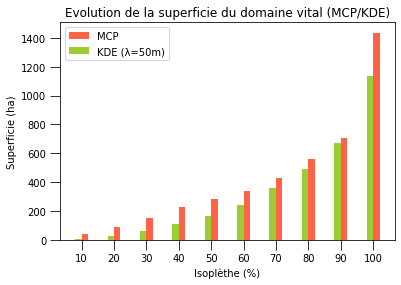

__init__: 0.239019 s


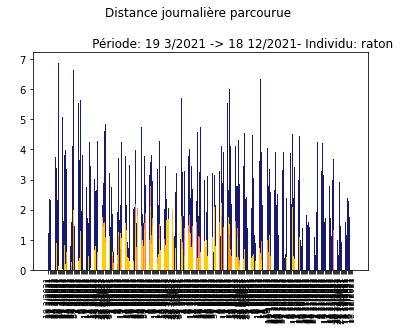

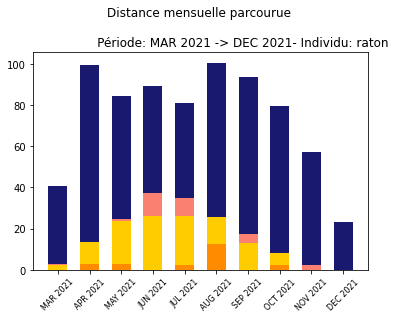

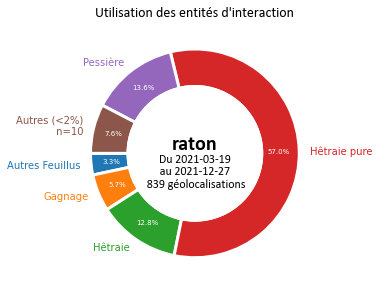

/Users/quentin/opt/miniconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/quentin/opt/miniconda3/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/quentin/opt/miniconda3/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated

             TYPE                                           GEOMETRY  \
25   MultiPolygon  (POLYGON ((670496.209149916 5552814.09379754, ...   
269  MultiPolygon  (POLYGON ((670783.7908007953 5550179.554242779...   
70   MultiPolygon  (POLYGON ((670792.4632938615 5550425.501003968...   
15   MultiPolygon  (POLYGON ((671864.8543162786 5549952.394776490...   
37   MultiPolygon  (POLYGON ((671686.1871705996 5549315.880718603...   
..            ...                                                ...   
177  MultiPolygon  (POLYGON ((670565.4786816335 5550259.483464314...   
293  MultiPolygon  (POLYGON ((671186.6944760199 5552710.27720167,...   
219  MultiPolygon  (POLYGON ((671129.3128167087 5550608.105842003...   
152  MultiPolygon  (POLYGON ((671666.6519655135 5551677.170213629...   
300  MultiPolygon  (POLYGON ((671081.744183919 5550502.367181226,...   

               CLASS    ID  HAS_INTERACTION  AREA_HA  \
25           Hêtraie  1640             True    32.61   
269     Hêtraie pure  5

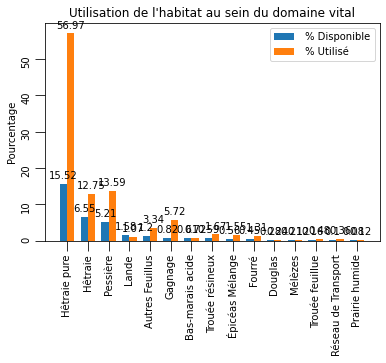

create_metrics: 2e-06 s
get_folder_name: 4.3e-05 s
create_main_folder: 0.000996 s
create_subfolders: 0.000385 s
export_data: 0.891479 s
Map available in ../output/raton_from_20210701_to_20210830(16)/map/map_raton_from_20210701_to_20210830.html
export_map: 1.15784 s
export_logger_metrics: 0.086251 s
export_settings: 0.001052 s
export_MCP: 0.00526 s


/Users/quentin/opt/miniconda3/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/quentin/opt/miniconda3/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/quentin/opt/miniconda3/lib/python3.9/site-packages/pandas/io/formats/printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
/Users/que

export_plots: 5.823882 s
create_zip_file: 0.443509 s
run: 22.491573 s
##### LOGGER #####
{'converter': {'UTM_CRS': 'EPSG:32631', 'WGS84': 'EPSG:4326'},
 'datachecker': {'application_timestamp': '05/08/22 21:54:02',
                 'bounds': {'max_lat': 50.10178375,
                            'max_lon': 5.429199219,
                            'min_lat': 50.05259705,
                            'min_lon': 5.375970364},
                 'duration': Timedelta('282 days 07:59:17'),
                 'first_date': Timestamp('2021-03-19 20:01:05+0000', tz='GMT'),
                 'last_date': Timestamp('2021-12-27 04:00:22+0000', tz='GMT'),
                 'n_locations': 1179,
                 'time_format': '%d/%m/%Y %H:%M:%S %Z'},
 'datacleaner': {'first_date': datetime.date(2021, 3, 19),
                 'last_date': datetime.date(2021, 12, 27)},
 'datacomputer': {'nlocs_period': {'dawn': 27,
                                   'day': 288,
                                   'dusk': 58,
 

In [74]:
if __name__ == "__main__":
    T = TracksMining()
    T.run()
    
    #T.data.display_locations()
    #T.data.display_locations_columns()
    T.logger.display()
    T.settings.display()